In [1]:
import numpy as np
from numpy import cos, sin, arctan2
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.ticker import LinearLocator
import cvxpy as cp
from scipy.optimize import least_squares, minimize
import networkx as nx
# import mrob
import pandas as pd
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [2]:
class Landmark():
    def __init__(self, x, y, id):
        self.x = x
        self.y = y
        self.id = id
    def get_data(self):
        return np.array([self.x, self.y, self.id])
    
class Pose():
    def __init__(self, x, y, phi):
        self.x = x
        self.y = y
        self.phi = wrap_angle(phi)
        
    def get_data(self):
        return np.array([self.x, self.y, self.phi])
    
    def set_data(self, x, y, phi):
        self.x = x
        self.y = y
        self.phi = wrap_angle(phi)

In [3]:
def wrap_angle(angle):
      while angle > np.pi:
        angle -= 2.0 * np.pi
      while angle < -np.pi:
        angle += 2.0 * np.pi
      return angle

def get_R(phi):
    phi = wrap_angle(phi)
    R = np.array([[cos(phi),-sin(phi),0],
                  [sin(phi), cos(phi),0],
                      [0,      0,     1]])
    return R

def get_g(pose_i, measurement):
    rot1, trans, rot2 = measurement[0],measurement[1],measurement[2]
    phi = pose_i.get_data()[2]
    delta = np.array([trans*cos(wrap_angle(phi+rot1)),trans*sin(wrap_angle(phi+rot1)),wrap_angle(rot1+rot2)])
    g = pose_i.get_data() + delta
    return g

    
def get_G(pose_i, measurement):
    rot1, trans, rot2 = measurement[0],measurement[1],measurement[2]
    phi = pose_i.get_data()[2]
    G = np.array([[[1],[0],[-trans*sin(wrap_angle(phi+rot1))]],
                  [[0],[1],[ trans*cos(wrap_angle(phi+rot1))]],
                  [[0],[0],         [1]]])
    return G.squeeze()

def get_h(pose_i, pose_j):
    dx = pose_j.get_data()[0]-pose_i.get_data()[0]
    dy = pose_j.get_data()[1]-pose_i.get_data()[1]
    d_phi = pose_j.get_data()[2]-pose_i.get_data()[2]
    phi_i = pose_i.get_data()[2]
    delta_X = np.array([dx,dy,d_phi])
    R = get_R(phi_i)
    return R.T @ delta_X

def get_H(pose_i, pose_j):
    dx = pose_j.get_data()[0]-pose_i.get_data()[0]
    dy = pose_j.get_data()[1]-pose_i.get_data()[1]
    phi_i = pose_i.get_data()[2]

    H = np.array([[[-cos(phi_i)],[-sin(phi_i)],[-dx*sin(phi_i)+dy*cos(phi_i)]],
                  [[sin(phi_i)], [-cos(phi_i)],[-dx*cos(phi_i)-dy*sin(phi_i)]],
                  [[0],            [0],               [-1]]])
    
    return H.squeeze()

In [4]:
def generate_poses(amount):
    poses = []
    for i in range(amount):
        poses.append(Pose(0,0,0))
    return poses

def generate_odom_measurements_mrob(GT_traj, noises):
  measurements = np.zeros(shape=(GT_traj.shape[0]-1,3))
  for i in range(measurements.shape[0]):
      d_trans = np.sqrt((GT_traj[i+1,0]-GT_traj[i,0])**2 + (GT_traj[i+1,1]-GT_traj[i,1])**2)
      d_rot1 = arctan2(GT_traj[i+1,1]-GT_traj[i,1],GT_traj[i+1,0]-GT_traj[i,0])-GT_traj[i,2]
      d_rot2 = wrap_angle(GT_traj[i+1,2]-GT_traj[i,2]-d_rot1)
      measurements[i,0] = d_rot1 + np.random.normal(loc=0.0, scale=noises[2], size=1)
      measurements[i,1] = d_trans + np.random.normal(loc=0.0, scale=noises[0], size=1)
      measurements[i,2] = d_rot2 + np.random.normal(loc=0.0, scale=noises[2], size=1)
      measurements[i,2] = wrap_angle(measurements[i,2])
  return measurements

def integrate_measurements(start_pose, measurements):
    poses = np.zeros(shape=(measurements.shape[0]+1,3))
    poses[0,:] = start_pose
    for i in range(measurements.shape[0]):
        rot1, trans, rot2 = measurements[i,0],measurements[i,1],measurements[i,2]
        phi = poses[i,2]
        delta = np.array([trans*cos(phi+rot1),trans*sin(phi+rot1),rot1+rot2])
        poses[i+1] = poses[i,:] + delta
        poses[i+1,2] = wrap_angle(poses[i+1,2])
    return poses

In [5]:
class RS_element:
    def __init__(self):
        self.type = "s"
        self.start_point = [0,0]
        self.length = 0
        
class Path:
    def __init__(self):
        self.rs_elements = []
        self.path_points = []
        
def generate_odom(poses):
    measurments_amount = poses.shape[0]-1
    measurements = np.zeros(shape=(measurments_amount,3))
    for i in range(measurments_amount):
        measurements[i,:] = poses[i+1,:] - poses[i,:]
    return measurements

def make_trajectory(elem_types, start, sigma_xy, sigma_theta):
    np.random.seed(0)
    MAX_STEER = 0.6
    CAR_LENGTH = 1.5
    RESOLUTION = 0.2
    U_MAX = 0.5#np.tan(MAX_STEER) / CAR_LENGTH
    

    def move(x, y, yaw, distance, u):
        noise_x = np.random.normal(loc=0, scale=sigma_xy, size=1)[0]
        noise_y = np.random.normal(loc=0, scale=sigma_xy, size=1)[0]
        noise_yaw = np.random.normal(loc=0, scale=sigma_theta, size=1)[0]
        x += distance * cos(yaw)+ noise_x
        y += distance * sin(yaw)+ noise_y
        yaw = wrap_angle(yaw + distance * u)+ noise_yaw
        return x, y, yaw
    
    path_point = [start]
    x, y, yaw = start
    trajectory_types = elem_types
    trajectory = Path()
    for rs_elem in trajectory_types:
        elem = RS_element()
        elem.type = rs_elem[0]
        elem.length = rs_elem[1]
        elem.start_point = [x,y, yaw]
        trajectory.rs_elements.append(elem)
        if(elem.type =="r"):
            u = -U_MAX
        elif(elem.type =="l"):
            u = U_MAX
        else:
            u = 0

        length = 0
        while length <  abs(elem.length):
            x,y, yaw = move(x, y, yaw, RESOLUTION*np.sign(rs_elem[1]), u)
            length+=RESOLUTION
            path_point.append([x,y, yaw ])
            
    path_point = np.array(path_point)  
    trajectory.path_points = path_point
    return trajectory

In [6]:
def LM_solver(A, b, poses):
    def func(x, A, b):
        return np.power((A @ x - b),2)
    solution = least_squares(func, x0=poses, args=(A,b),  method='lm')
    return solution.x

In [7]:
def MSE(GT_traj, traj):
  mse_rot = np.mean(np.power((GT_traj[:,2]-traj[:,2]),2))
  mse_trans = np.mean(np.power((GT_traj[:,:2]-traj[:,:2]),2))
  return mse_trans, mse_rot

In [8]:
def generate_loop_measurements(trajectory_GT, k=5):
    m = trajectory_GT.shape[0] // k
    loops = []
    random_i = np.random.randint(low=0, high=trajectory_GT.shape[0], size=m)[None, :]
    random_j = np.random.randint(low=0, high=trajectory_GT.shape[0], size=m)[None, :]
    random_loop_idxs = np.vstack((random_i, random_j))
    random_loop_idxs = random_loop_idxs[:, ~np.all(random_loop_idxs[1:] == random_loop_idxs[:-1], axis=0)] # removing duplicate idxs

    for i in range(random_loop_idxs.shape[1]):
      # idx_i = random_loop_idxs[0,i]
      idx_i = 0
      idx_j = random_loop_idxs[1,i]
      phi = trajectory_GT[idx_i][2]
      R_T = np.array([[cos(phi),  sin(phi),  0],
                     [-sin(phi), cos(phi),  0],
                     [0,           0,       1]])
      loops.append(np.array([idx_i, idx_j, *(R_T @ (trajectory_GT[idx_j] - trajectory_GT[idx_i]))])[None,:])

    loop_measurements = np.array(loops).reshape((len(loops)*loops[0].shape[0] , -1))
    return loop_measurements

In [9]:
def make_H(pose_i, pose_j, idx_i, idx_j):
    dx, dy = (pose_j.get_data() - pose_i.get_data())[:-1]
    phi = pose_i.get_data()[2]
    
    H_i = np.array([[-cos(phi), -sin(phi),  -sin(phi)*dx + cos(phi)*dy],
                    [ sin(phi), -cos(phi),  -cos(phi)*dx - sin(phi)*dy],
                    [0,           0,                                -1]])
    
    H_j = np.array([[cos(phi),  sin(phi),  0],
                    [-sin(phi), cos(phi),  0],
                    [0,           0,       1]])

    return H_i, H_j
    
def make_A(poses, odom_measurements, odom_covariance, loop_measurements, loop_covariance):

    def add_odom_factor(poses, idx,  odom_measurements, odom_E, A, b):
        k = odom_measurements.shape[0]
        A = np.pad(A, ((0,3*k),(0,3)), mode='constant', constant_values=0)
        for i in range(k):
          pose_i_idx, pose_j_idx = idx, idx+1
          pose_i, pose_j = poses[pose_i_idx], poses[pose_j_idx]
          G = get_G(pose_i, odom_measurements[i, idx, :])
          g = get_g(pose_i, odom_measurements[i, idx, :])

          row_i, row_j = -3*k+3*i, -3*k+3*(i+1)
          if(row_j == 0):
              A[row_i : , 3*pose_i_idx:3*(pose_i_idx+1)] = odom_E[i,:,:] @ G
              A[row_i : , 3*pose_j_idx:3*(pose_j_idx+1)] = odom_E[i,:,:] @ -I
          else:
              A[row_i : row_j, 3*pose_i_idx:3*(pose_i_idx+1)] = odom_E[i,:,:] @ G
              A[row_i : row_j, 3*pose_j_idx:3*(pose_j_idx+1)] = odom_E[i,:,:] @ -I

          error = pose_j.get_data() - g
          error[2] = wrap_angle(error[2])
          b = np.hstack((b, odom_E[i,:,:] @ error))
          chi2.append(0.5*error @ (odom_E[i,:,:] @ error))
        return A, b
        

    def add_loop_factor(poses, measurement, loop_E, A, b):
        A = np.pad(A, ((0,3),(0,0)), mode='constant', constant_values=0)
        pose_i_idx, pose_j_idx = int(measurement[0]), int(measurement[1])
        pose_i, pose_j = poses[pose_i_idx], poses[pose_j_idx]
        H_i, H_j = make_H(pose_i, pose_j, pose_i_idx, pose_j_idx)

        A[-3 : , 3*pose_i_idx : 3*(pose_i_idx+1)] = loop_E @ H_i
        A[-3 : , 3*pose_j_idx : 3*(pose_j_idx+1)] = loop_E @ H_j

        phi = pose_i.get_data()[2]
        R_T = np.array([[cos(phi),  sin(phi),  0],
                      [-sin(phi), cos(phi),  0],
                      [0,           0,       1]])
        residual = R_T @ (pose_j.get_data()-pose_i.get_data())
        error = (measurement[2:]-residual)

        b = np.hstack((b, loop_E @ error))

        chi2.append(0.5*error @ (loop_E @ error))
        return A, b
    
    odom_E = np.sqrt(np.linalg.inv(odom_covariance))
    loop_E = np.sqrt(np.linalg.inv(loop_covariance))
    # odom_E, loop_E = normilize_weights(odom_E, loop_E)
    I = np.identity(3)
    A = 1e3*I #first pose
    b = np.zeros(shape=(3))
    chi2 = []
    #odom_factor:
    for i in range(odom_measurements.shape[1]):
        A, b = add_odom_factor(poses, i, odom_measurements, odom_E, A, b)
    
    #loop_factor: 
    for i in range(loop_measurements.shape[0]): 
        A, b, = add_loop_factor(poses, loop_measurements[i,:], loop_E, A, b)

    return A, b, chi2

In [10]:
def poses_as_array(poses):
    poses_array = np.zeros(shape=(len(poses),3))
    for i in range(len(poses)):
        poses_array[i,:] = poses[i].get_data()
    return poses_array

def update_poses(poses, deltas):
    for i in range(len(poses)):
        x, y, phi = poses[i].get_data()
        dx = deltas[3*i:3*(i+1)][0]
        dy = deltas[3*i:3*(i+1)][1]
        d_phi = deltas[3*i:3*(i+1)][2]
        poses[i].set_data(x+dx,y+dy,phi+d_phi)
    return poses

def initialize_poses(poses, init_points):
  for i in range(len(poses)):
    x,y,phi = init_points[i,0],init_points[i,1],init_points[i,2]
    poses[i].set_data(x,y,phi)
  return poses

def normilize_weights(W1,W2):
    sum_diag = np.diagonal(W1+W2)
    for i in range(3):
        W1[i,i] = W1[i,i] / sum_diag[i]
        W2[i,i] = W2[i,i] / sum_diag[i]
    return W1, W2

$O_{b}(k^2N)+O_{A}(2k^2N) + O_{QR}(k^2N^3) + O_{solve}(k^2N^2) \sim O(N^3)$

as we need several iterations for convergence, in total:

$m [O_{A,b}(3k^2N) + O_{QR}(k^2N^3) + O_{solve}(k^2N^2)]$

$O_{A,b}(3k^2N) + O_{ostov}(N+M\log{M}) + O_{QR}(k^2N^3) + O_{solve}(k^2N^2)$

$O_{A,b}(3k^2N) + O_{ostov}(N) + O_{QR}(k^2N^3) + O_{solve}(k^2N^2)$

$N$ - number of measurements (edges)

$M$ - number of states (verices)

$k$ - dim of each state (vertex)

while $||δ||_2>=ϵ$:

&nbsp; 1) calculate $A, b$ around $X$, and $A=QR$

&nbsp;  2) solve $δ = R^{-1}Q^Tb$

&nbsp;  3) update $X := X + δ$

&nbsp;  4) residual $=||Ax-b||_2$


In [11]:
def run_experiment(X0, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters = 5):
    residuals = []
    deltas_norms = []
    poses = X0
    for i in range(iters):
        A, b, chi2 = make_A(poses, odom_measurements, odom_covariance, loop_measurements, loop_covariance)

        #QR solver
        Q, R = np.linalg.qr(A)
        deltas = np.linalg.inv(R) @ Q.T @ b
        deltas_norms.append(np.linalg.norm(deltas))
        poses = update_poses(poses, deltas)
        optimized_poses = poses_as_array(poses)
        norm = np.linalg.norm(np.linalg.norm(A @ deltas - b))
        residuals.append(norm)

    print(sum(chi2))
    trans_mse, rot_mse = MSE(trajectory_GT, optimized_poses)
    print(trans_mse, rot_mse)
    print('max pos err(m): ', "%.2f" % np.abs(np.max(trajectory_GT[:,:2]-optimized_poses[:,:2])))
    angle_err = np.array([wrap_angle(a) for a in list(trajectory_GT[:,2]-optimized_poses[:,2])])
    angle_err = angle_err / np.pi * 180
    print('max rot err(deg): ', "%.2f" % np.max(np.abs(angle_err)))
    return optimized_poses, residuals, deltas_norms, trans_mse, rot_mse, chi2

In [12]:
def solve_tree(poses, edge_list):
    def get_R(phi):
        R = np.array([[cos(phi), -sin(phi),  0],
                        [sin(phi), cos(phi),  0],
                        [0,           0,       1]])
        return R

    assert len(poses) == (len(edge_list)+1)

    solution = np.zeros(shape = (3*len(poses)))
    solution[:3] = poses[0].get_data()
    solution_list = [0]

    for edge in edge_list:
        edge_type = edge[3]['Type']
        measurement = edge[3]['measurement']

        if edge_type == 'odom':
            pose_i_idx = edge[0]
            pose_j_idx = edge[1]
            x, y, phi = solution[3*pose_i_idx:3*(pose_i_idx+1)][0], solution[3*pose_i_idx:3*(pose_i_idx+1)][1], solution[3*pose_i_idx:3*(pose_i_idx+1)][2]
            pose_i = Pose(x, y, phi)
            x = get_g(pose_i, measurement)

        if edge_type == 'loop':
            pose_i_idx = int(measurement[0])
            pose_j_idx = int(measurement[1])
            measurement = measurement[2:]
            if(pose_i_idx > pose_j_idx):
                measurement = -measurement
                tmp = pose_i_idx
                pose_i_idx = pose_j_idx
                pose_j_idx = tmp

            phi = solution[3*pose_i_idx:3*(pose_i_idx+1)][2]
            R = get_R(phi)
            x = solution[3*pose_i_idx:3*(pose_i_idx+1)] + R @ measurement

        solution[3*pose_j_idx: 3*(pose_j_idx+1)] = x
        solution_list.append(pose_j_idx)

    return solution

In [13]:
def Tree(odom_measurements_1, odom_measurements_2, odom_measurements_3, odom_measurements_4, odom_covariance_1, odom_covariance_2, odom_covariance_3, odom_covariance_4, loop_covariance, loop_measurements):
    #
    # IVAN
    #
    %matplotlib inline

    blue = 'b' 
    green = 'g'
    red = 'r'
    cyan = 'c'
    magenta='m'
    yellow='y'
    black='k'
    white='w'


    odom_meas_s = np.array([odom_measurements_1, odom_measurements_2, odom_measurements_3, odom_measurements_4])
    odom_covs = np.array([odom_covariance_1, odom_covariance_2, odom_covariance_3, odom_covariance_4])
    odom_weights = 1/odom_covs[:, 0, 0, 0]
    N = trajectory_GT.shape[0]
    loop_weight = 1/loop_covariance[0, 0]
    odom_colors = [blue, green, red, cyan]

    G = nx.MultiGraph()
    for i in range(N):
        G.add_node(int(i))

    for j, odom_measures in enumerate(odom_meas_s):
        for i, v in enumerate(odom_measures):
            G.add_edge(int(i), int(i+1), weight=odom_weights[j], measurement=v, covariance=odom_covs[j], Type='odom', color=odom_colors[j])

    for i in loop_measurements:
        G.add_edge(int(i[0]), int(i[1]), weight=loop_weight, measurement = i[[0, 1, 2, 3, 4]], covariance=loop_covariance, Type='loop', color=magenta)
    
    Tree = nx.algorithms.tree.minimum_spanning_edges(G)
    edgelist = list(Tree)
    start = [0, 0, wrap_angle(0/180*np.pi)]
    poses = generate_poses(trajectory_GT.shape[0])
    poses[0].set_data(start[0], start[1], start[2])
    poses = initialize_poses(poses, np.zeros_like(noised_trajectory)) # set init poses with odometry traj

    edgelist = sorted(edgelist)
    deltas = solve_tree(poses, edgelist)
    poses = update_poses(poses, deltas)
    ostov_poses = poses_as_array(poses)
    poses = solve_tree(poses, edgelist)
    return poses

In [14]:
import math
def cool_preSol(loop_measurements, odom_measurements):
    noised_trajectory = integrate_measurements(np.array([0, 0, 0]), odom_measurements)
    
    loop_mes = np.concatenate((np.array([[0, 0, 0, 0, 0]]),  loop_measurements.copy()))
    loop_mes=loop_mes[np.argsort(loop_mes[:,1])]
    cooler_traj = np.ndarray((0, 3))
    for i in range(1, len(loop_mes)):
        loc_traj = noised_trajectory[int(loop_mes[i-1, 1]):int(loop_mes[i, 1])+1]
        R1 = get_R(-loc_traj[0, 2]+loop_mes[i-1, 4])
        loc_traj1 = (R1@(loc_traj - loc_traj[0]).T).T + np.concatenate((loop_mes[i-1, [2, 3]], [0]))
        R2 = get_R(-loc_traj[-1, 2]+loop_mes[i, 4])
        loc_traj2 = (R2@(loc_traj - loc_traj[-1]).T).T+np.concatenate((loop_mes[i, [2, 3]], [0]))
        loc_traj3 = loc_traj.copy()
        N = len(loc_traj)-1
        loc_traj3 = (loc_traj2.T*np.linspace(0, 1, loc_traj2.shape[0])).T + (loc_traj1.T*np.linspace(1, 0, loc_traj2.shape[0])).T
        #for j in range(N+1):
        #    loc_traj3[j] = loc_traj2[j]*j/N+loc_traj1[j]*(N-j)/N
        cooler_traj = np.concatenate((cooler_traj, loc_traj3[:-1]))
    loc_traj = noised_trajectory[int(loop_mes[-1, 1]):]
    R1 = get_R(-loc_traj[0, 2]+loop_mes[-1, 4])
    loc_traj1 = (R1@(loc_traj - loc_traj[0]).T).T+loop_mes[-1, [2, 3, 4]]
    cooler_traj = np.concatenate((cooler_traj, loc_traj1))
    for j in range(1, len(cooler_traj)):
        dxy = cooler_traj[j, [0, 1]] - cooler_traj[j-1, [0, 1]]
        cooler_traj[j-1,2] = math.atan2(dxy[1],dxy[0])
    cooler_traj[-1, 2] = cooler_traj[-2, 2]
    cooler_traj[0, 2] = 0
    return cooler_traj

In [15]:
def gen_data(LoopCount=15):
    # trajectory_types = [["s", 10],["r", 10],["s", 10],["r", 10],["s", 10],["l", 10]]
    trajectory_types = [["s", 10],["l", 10],["s", 10],["l", 10],["r", 10],["s", 10]]
    # trajectory_types = [["s", 1],["l", 5]]
    # trajectory_types = [["s", 10]]
    start = [0, 0, wrap_angle(0/180*np.pi)]

    noise_1 = [0.1, 0.1, 0.1]
    noise_2 = [0.08, 0.08, 0.08]
    noise_3 = [0.07, 0.07, 0.07]
    noise_4 = [0.06, 0.06, 0.06]
    odom_covariance_1 = np.diag(noise_1)[None,:]
    odom_covariance_2 = np.diag(noise_2)[None,:]
    odom_covariance_3 = np.diag(noise_3)[None,:]
    odom_covariance_4 = np.diag(noise_4)[None,:]
    odom_covariance = np.vstack((odom_covariance_1, odom_covariance_2, odom_covariance_3, odom_covariance_4))

    trajectory_GT = make_trajectory(trajectory_types, start, 0.0,0.0).path_points
    odom_measurements_1 = generate_odom_measurements_mrob(trajectory_GT, [noise_1[0], noise_1[1], noise_1[2]])
    odom_measurements_2 = generate_odom_measurements_mrob(trajectory_GT, [noise_2[0], noise_2[1], noise_2[2]])
    odom_measurements_3 = generate_odom_measurements_mrob(trajectory_GT, [noise_3[0], noise_3[1], noise_3[2]])
    odom_measurements_4 = generate_odom_measurements_mrob(trajectory_GT, [noise_4[0], noise_4[1], noise_4[2]])

    odom_measurements = np.vstack((odom_measurements_1[None,:], odom_measurements_2[None,:], odom_measurements_3[None,:], odom_measurements_4[None,:]))

    noised_trajectory = integrate_measurements(start, odom_measurements_1)

    loop_covariance = np.diag([1.0, 1.0, 1.0])
    loop_measurements = generate_loop_measurements(trajectory_GT, k=trajectory_GT.shape[0]//LoopCount)
    return loop_measurements, loop_covariance, odom_measurements, odom_covariance, odom_measurements_1, odom_measurements_2, odom_measurements_3, odom_measurements_4,odom_covariance_1, odom_covariance_2, odom_covariance_3, odom_covariance_4,trajectory_GT,noised_trajectory

In [16]:
def RUN_EXP(traj, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters, noised_trajectory):
    start = np.array([0, 0, 0])
   
    poses = generate_poses(trajectory_GT.shape[0])
    poses[0].set_data(start[0], start[1], start[2])
    poses = initialize_poses(poses, traj)
    
    optimized_poses,residuals, deltas_norms, trans_mse, rot_mse, chi2 = run_experiment(poses, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters = 2)
    
    %matplotlib inline
    start = 0
    k = trajectory_GT.shape[0]
    stp = 1
    scale = 0.2
    fig, ax = plt.subplots(figsize=(10,10),dpi=150)
    ax.scatter(trajectory_GT[start:k,0],trajectory_GT[start:k,1], s=scale, label='GT',c='blue')
    ax.scatter(noised_trajectory[start:k,0],noised_trajectory[start:k,1], s=scale, label='Odom',c='orange')
    ax.scatter(traj[start:k,0],traj[start:k,1], s=scale, label='Zero step',c='magenta')

    legend = ax.legend(loc='upper left', shadow=False, fontsize=12, labelcolor=['blue','orange', 'magenta'])
    plt.xlabel("X meters")
    plt.ylabel("Y meters")

    plt.quiver(trajectory_GT[start:k:stp,0],trajectory_GT[start:k:stp,1],
               scale*np.cos(trajectory_GT[start:k:stp,2]),
               scale*np.sin(trajectory_GT[start:k:stp,2]),
               color='blue',width=0.002, angles='xy', scale_units='xy', scale=1.0)

    plt.quiver(noised_trajectory[start:k:stp,0],noised_trajectory[start:k:stp,1],
               scale*np.cos(noised_trajectory[start:k:stp,2]),
               scale*np.sin(noised_trajectory[start:k:stp,2]),
               color='orange',width=0.002, angles='xy', scale_units='xy', scale=1.0)
    plt.quiver(traj[start:k:stp,0],traj[start:k:stp,1],
               scale*np.cos(traj[start:k:stp,2]),
               scale*np.sin(traj[start:k:stp,2]),
               color='magenta',width=0.002, angles='xy', scale_units='xy', scale=1.0)
    global NUM
    plt.savefig("cool "+str(NUM)+".png")
    NUM+=1
    plt.show()
    fig, ax = plt.subplots(figsize=(10,10),dpi=150)
    ax.scatter(trajectory_GT[start:k,0],trajectory_GT[start:k,1], s=scale, label='GT',c='blue')
    ax.scatter(noised_trajectory[start:k,0],noised_trajectory[start:k,1], s=scale, label='Odom',c='orange')
    ax.scatter(optimized_poses[start:k,0],optimized_poses[start:k,1], s=scale, label='Optimized',c='green')

    legend = ax.legend(loc='upper left', shadow=False, fontsize=12, labelcolor=['blue','orange','green'])
    plt.xlabel("X meters")
    plt.ylabel("Y meters")

    plt.quiver(trajectory_GT[start:k:stp,0],trajectory_GT[start:k:stp,1],
               scale*np.cos(trajectory_GT[start:k:stp,2]),
               scale*np.sin(trajectory_GT[start:k:stp,2]),
               color='blue',width=0.002, angles='xy', scale_units='xy', scale=1.0)

    plt.quiver(noised_trajectory[start:k:stp,0],noised_trajectory[start:k:stp,1],
               scale*np.cos(noised_trajectory[start:k:stp,2]),
               scale*np.sin(noised_trajectory[start:k:stp,2]),
               color='orange',width=0.002, angles='xy', scale_units='xy', scale=1.0)
    plt.quiver(optimized_poses[start:k:stp,0],optimized_poses[start:k:stp,1],
               scale*np.cos(optimized_poses[start:k:stp,2]),
               scale*np.sin(optimized_poses[start:k:stp,2]),
               color='green',width=0.002, angles='xy', scale_units='xy', scale=1.0)
    plt.savefig("cool "+str(NUM)+".png")
    NUM+=1
    plt.show()
    return optimized_poses,residuals, deltas_norms, trans_mse, rot_mse, chi2

In [17]:
NUM = 0


Zeros
123.44130748317653
2.564054778202988 1.7799411364748539
max pos err(m):  5.19
max rot err(deg):  176.86


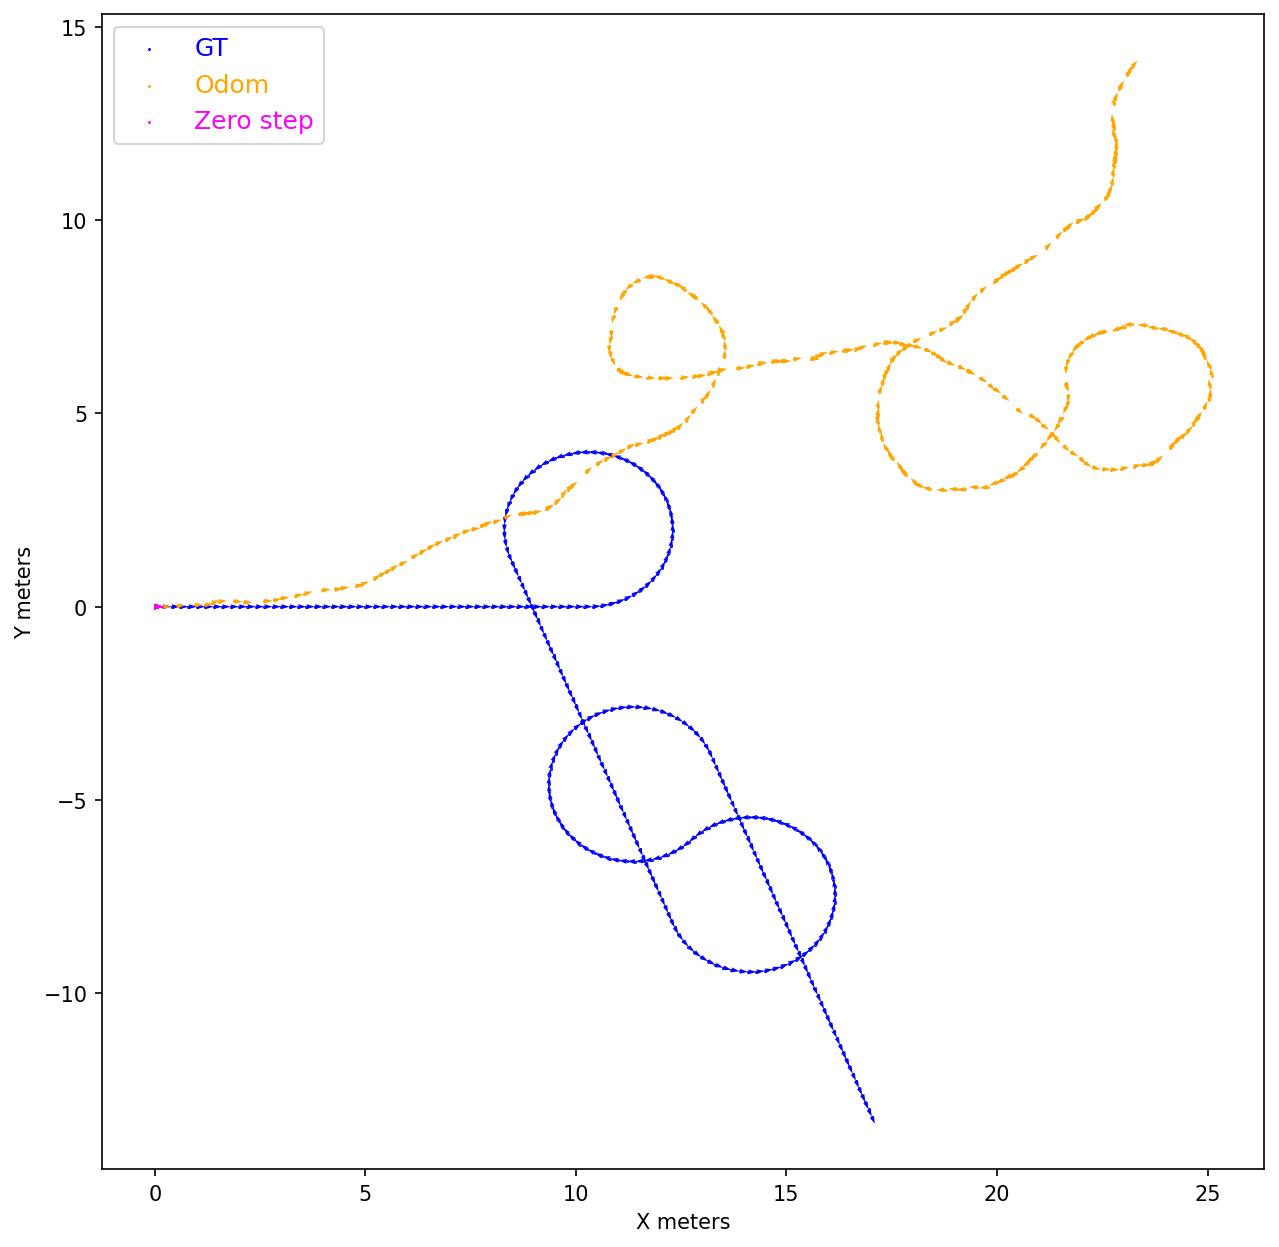

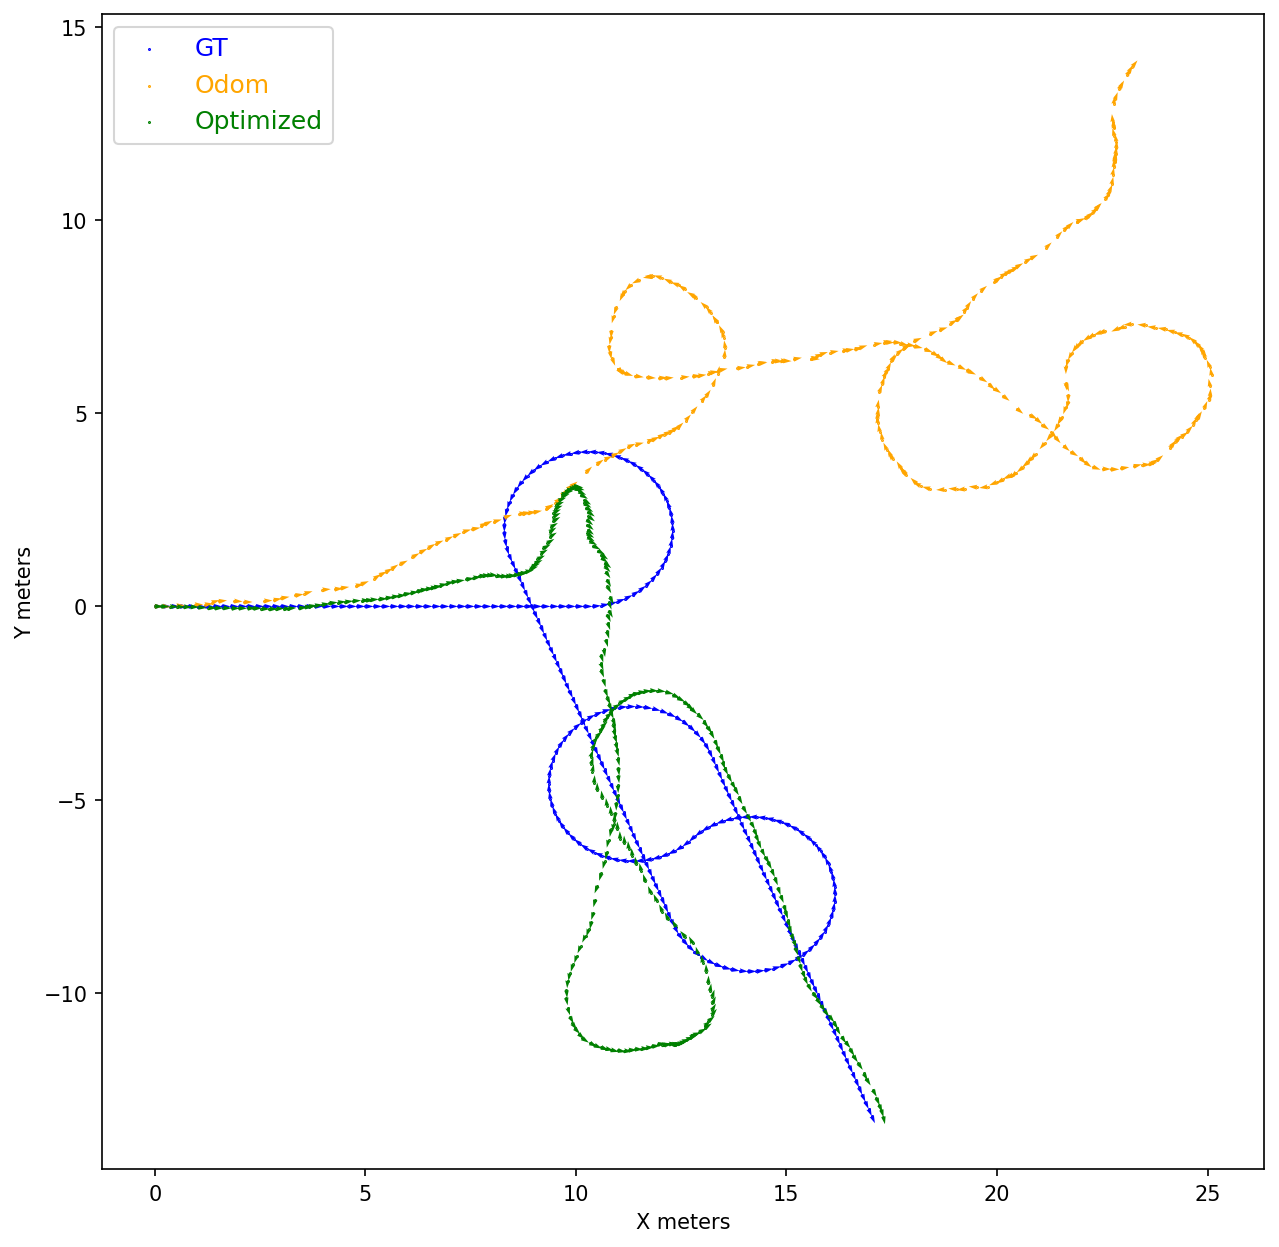


Random
1402.2107222487532
216.45360156464713 6.265063803502012
max pos err(m):  33.30
max rot err(deg):  178.83


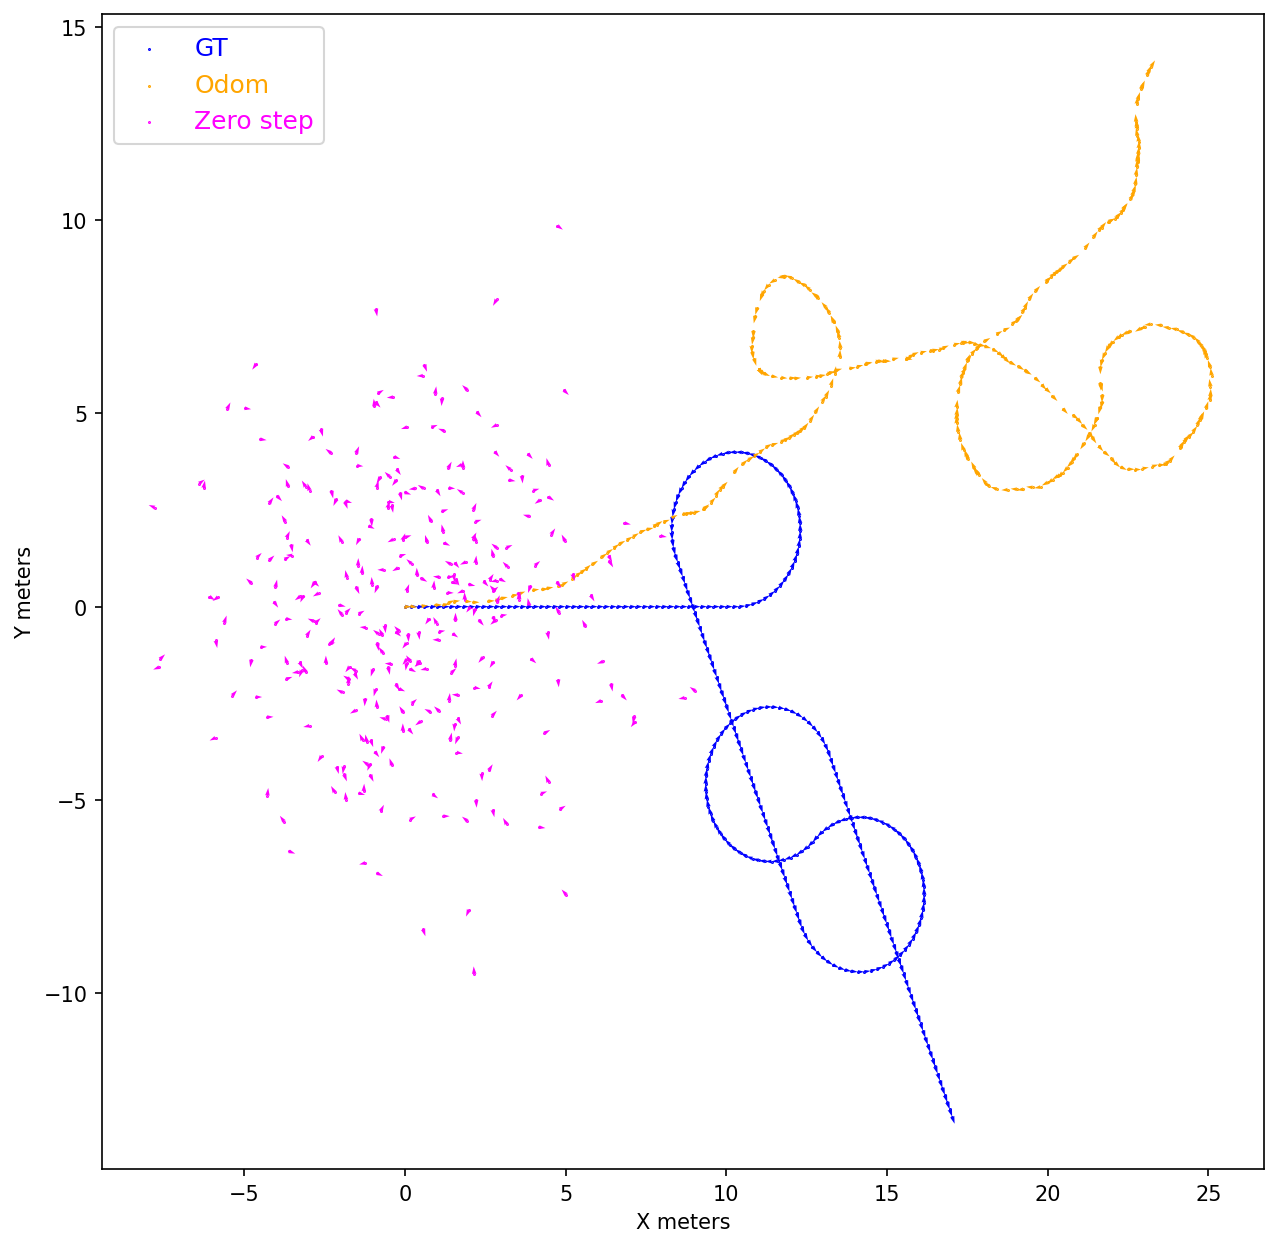

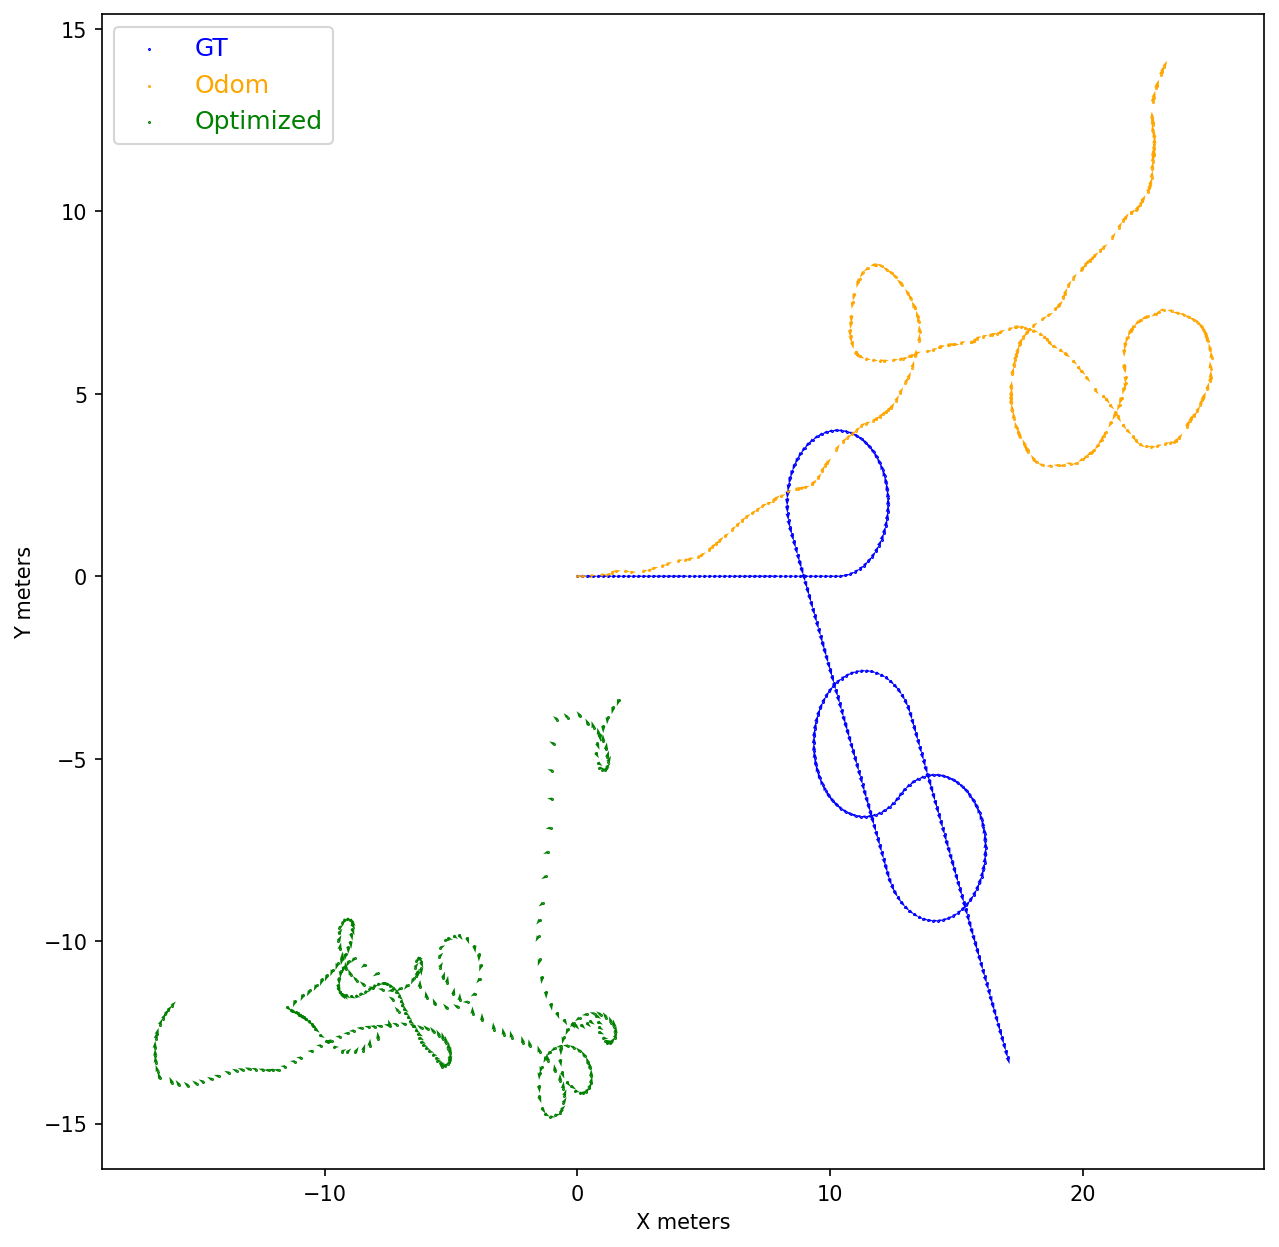


Odom 1
111.25088793061167
0.28338913507980845 1.2561148027707314
max pos err(m):  1.40
max rot err(deg):  80.33


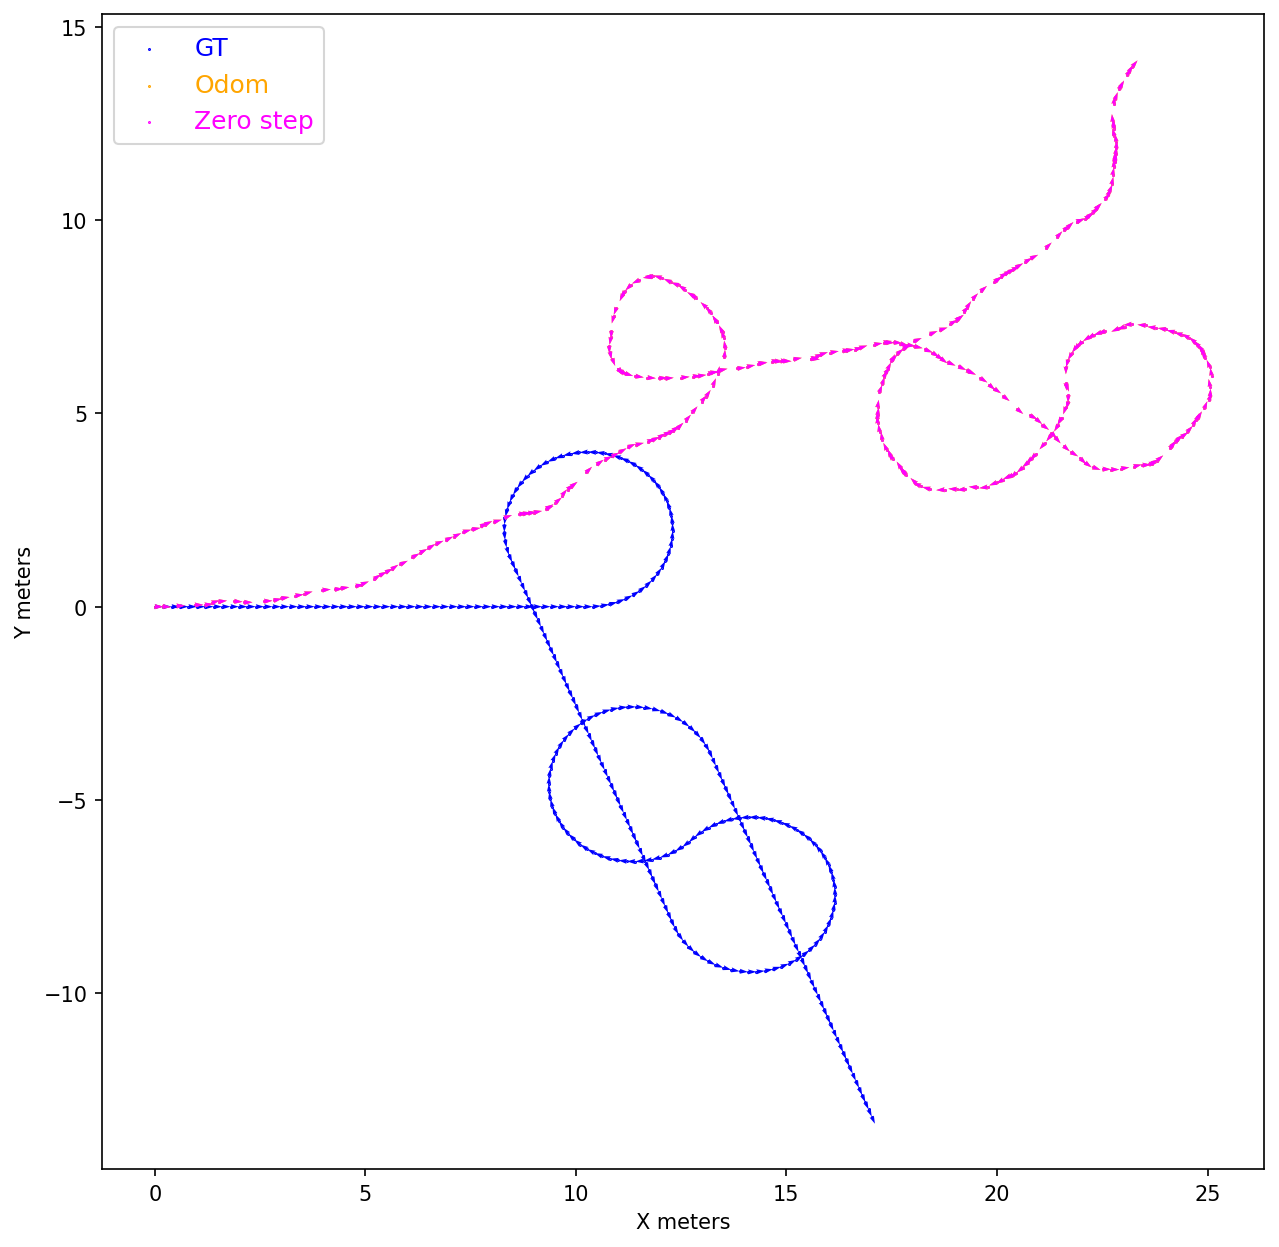

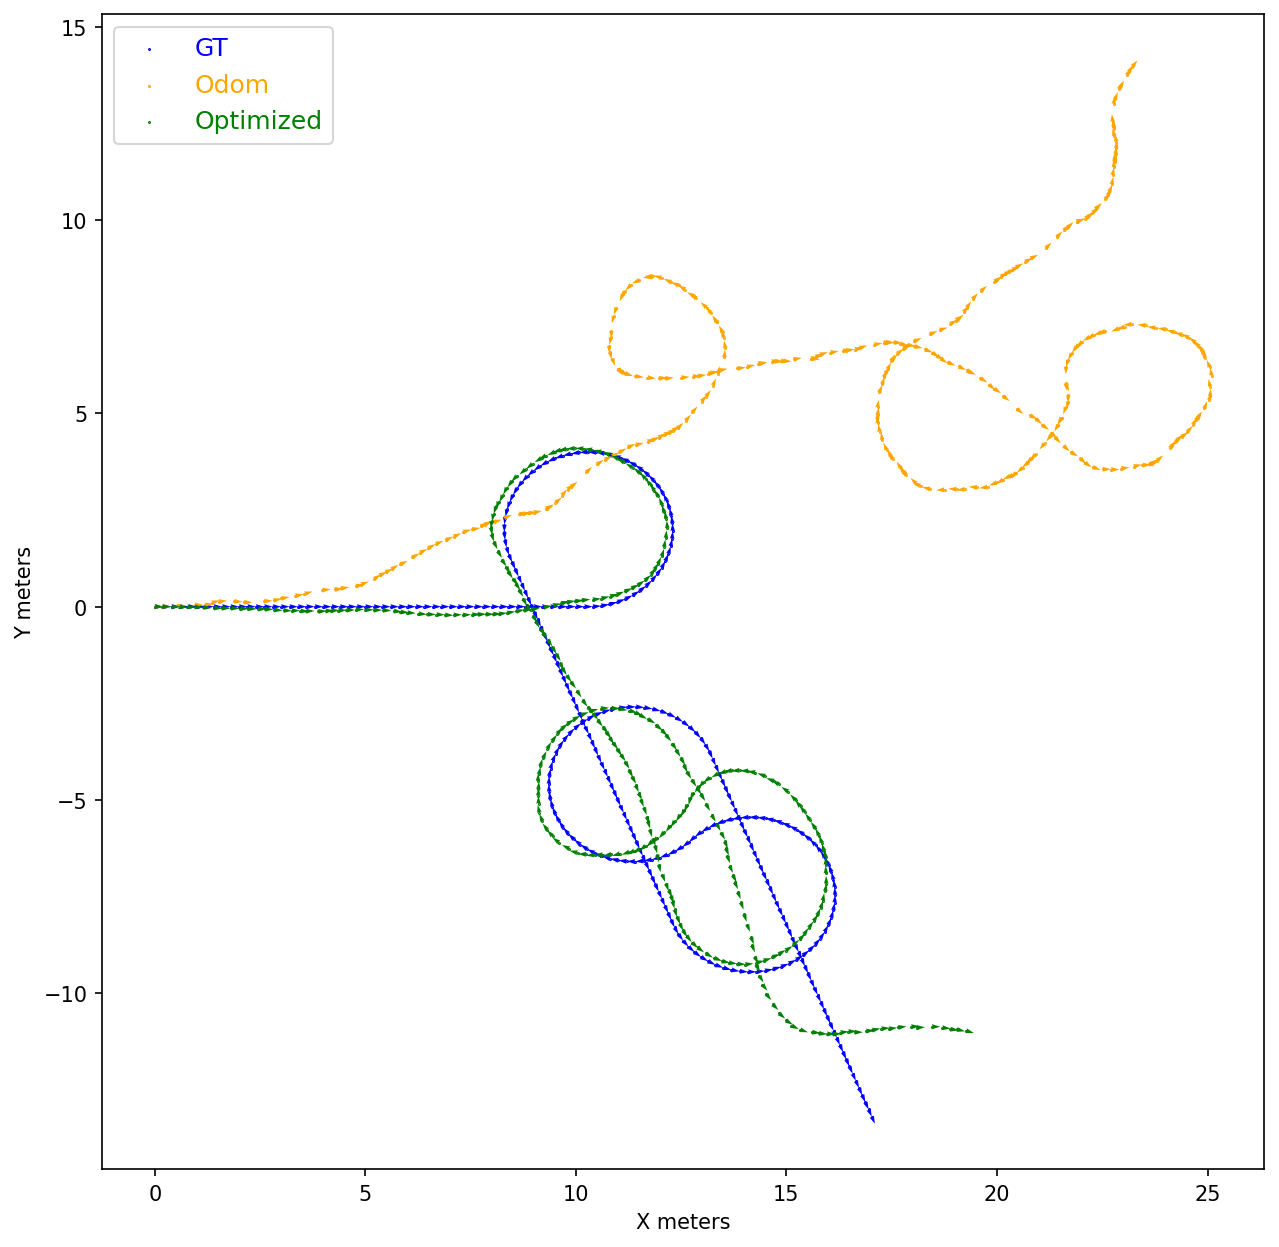


Odom 4
75.84445226243935
0.33956233986070883 1.7047667647118594
max pos err(m):  1.95
max rot err(deg):  46.51


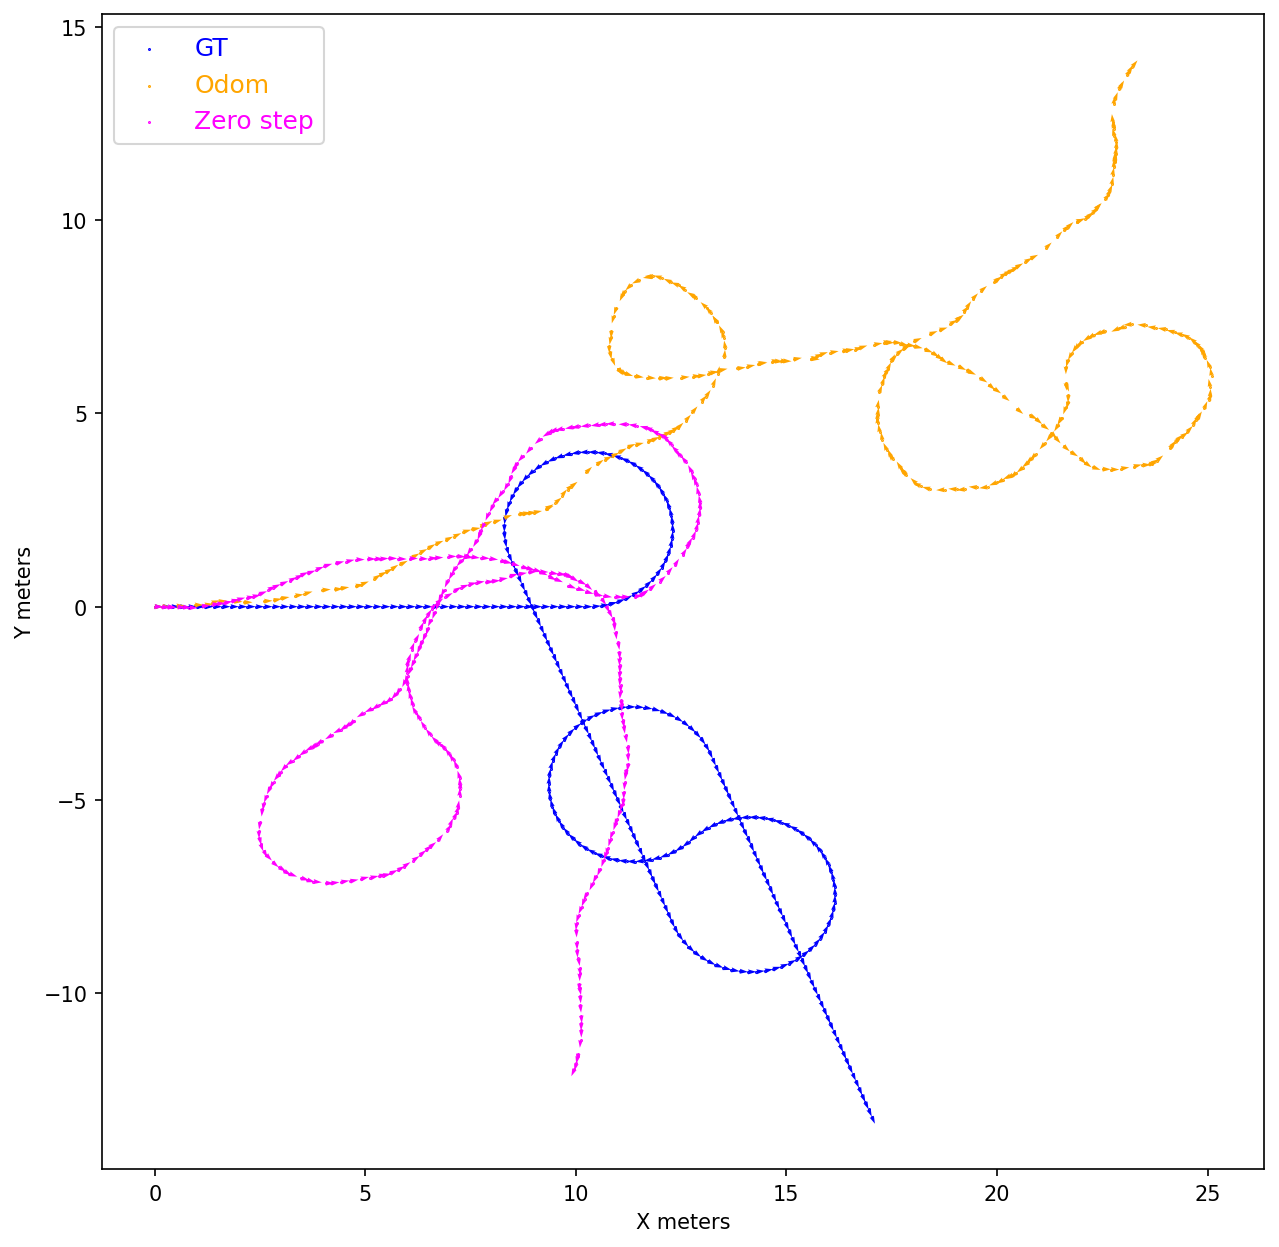

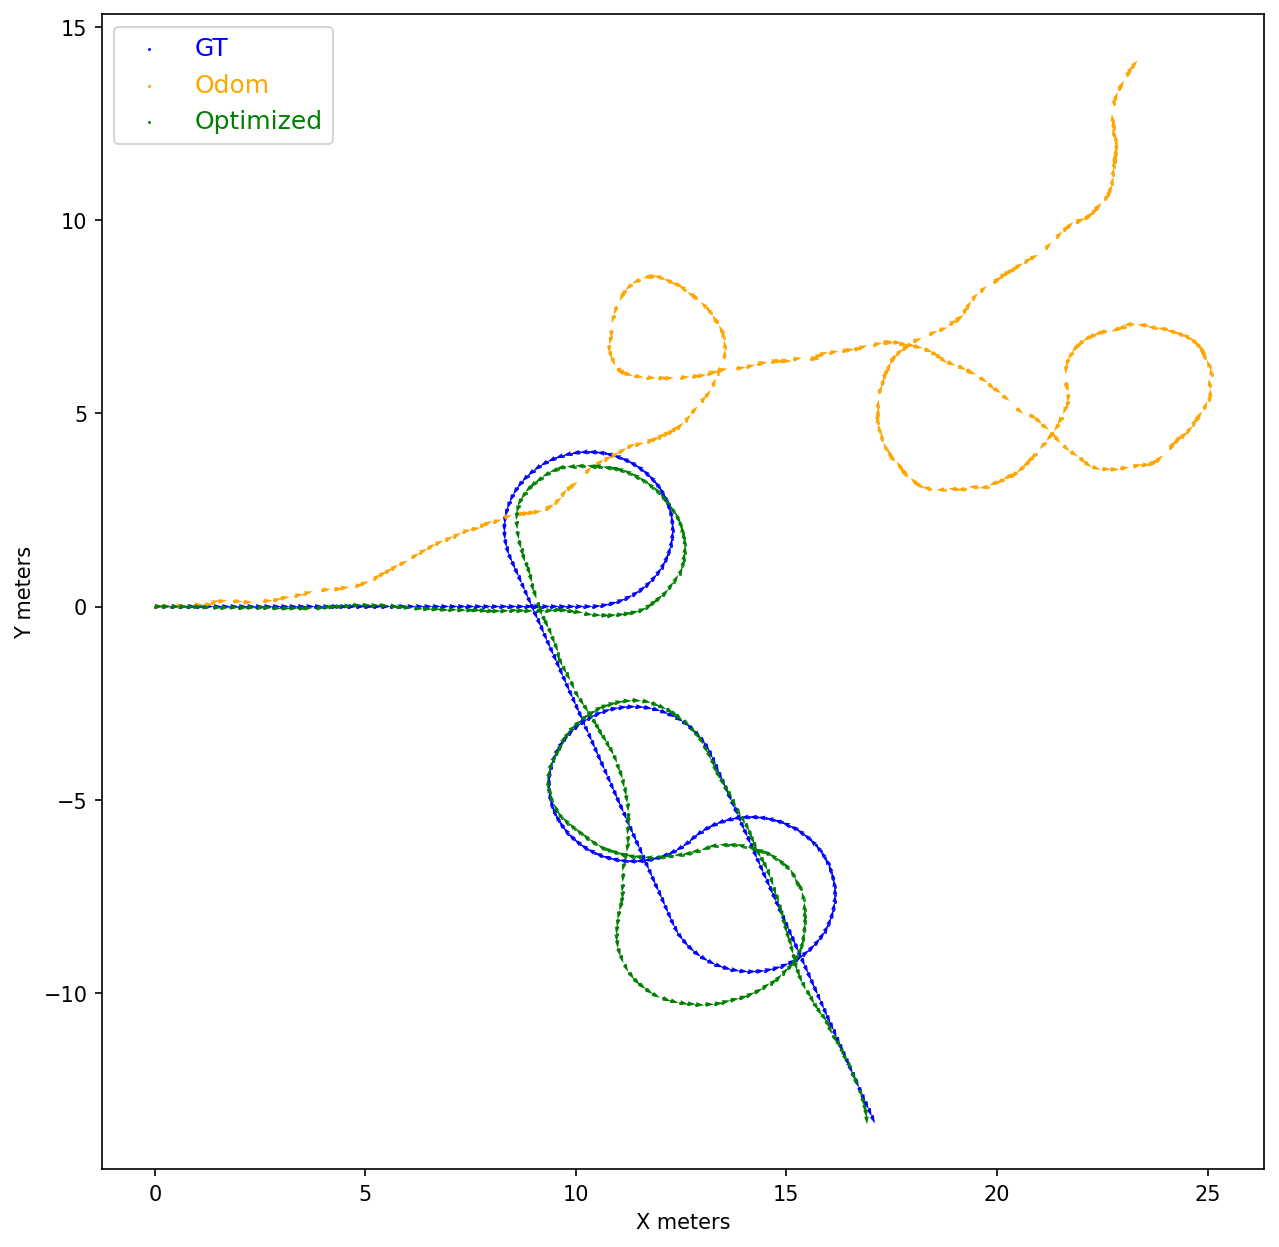


Cool 1
31.786763415781387
0.00985928406363159 0.008570028667280202
max pos err(m):  0.24
max rot err(deg):  17.37


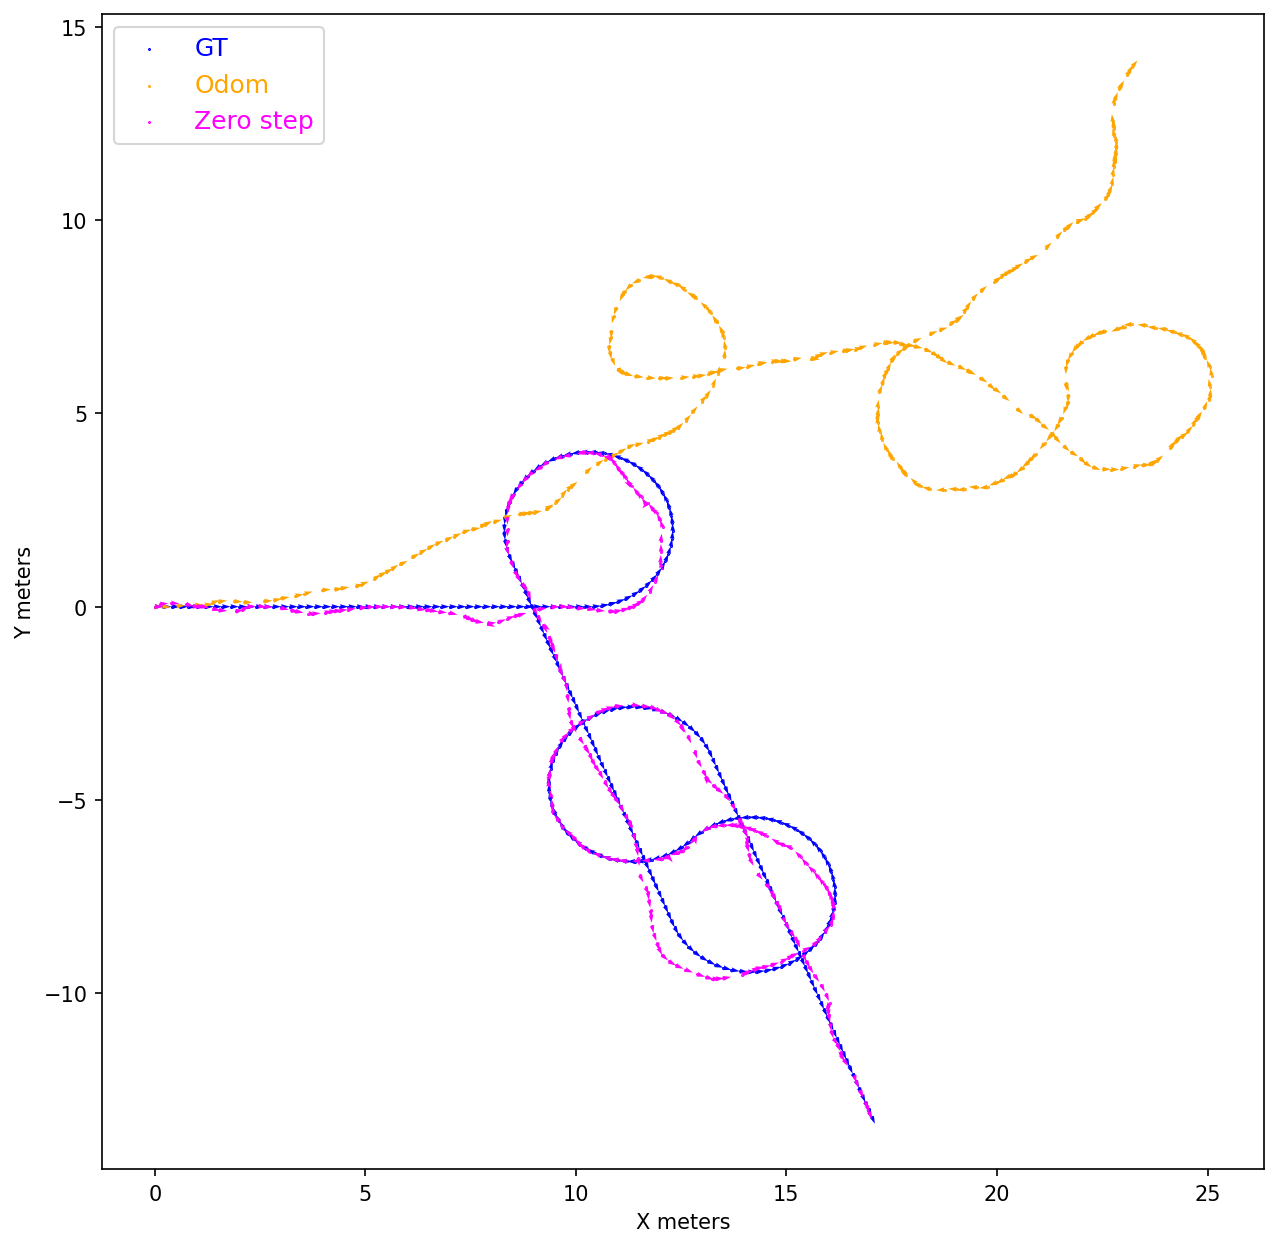

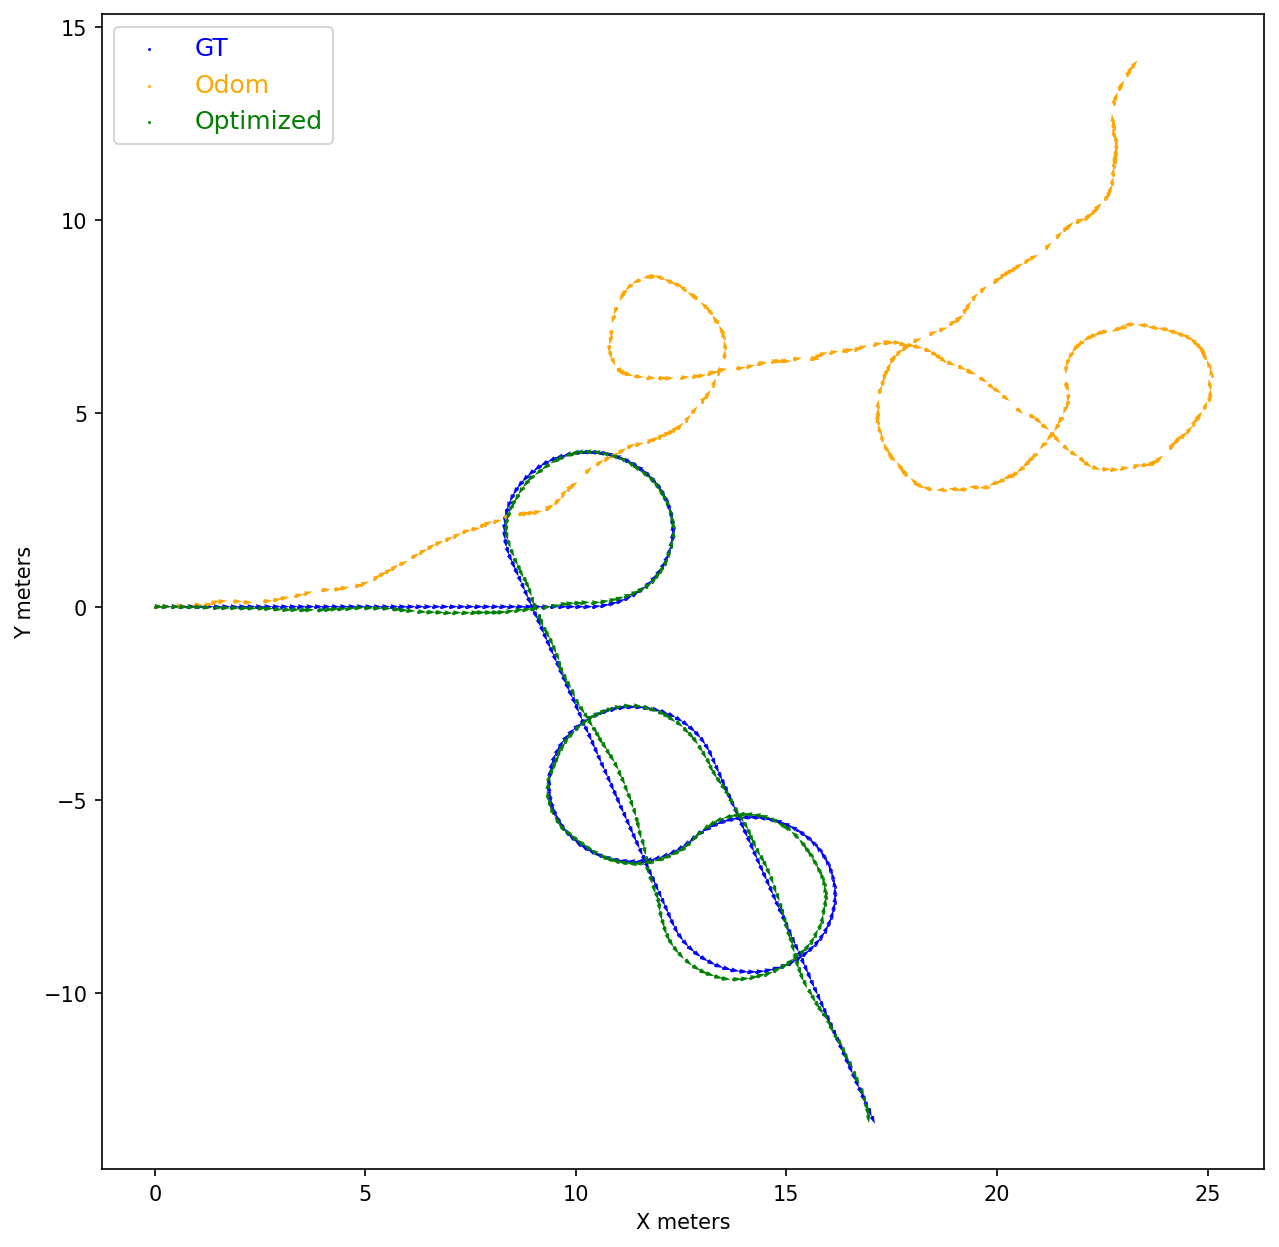


Cool 4
47.37278279304509
0.018032506395779958 0.3540304020938407
max pos err(m):  0.25
max rot err(deg):  22.51


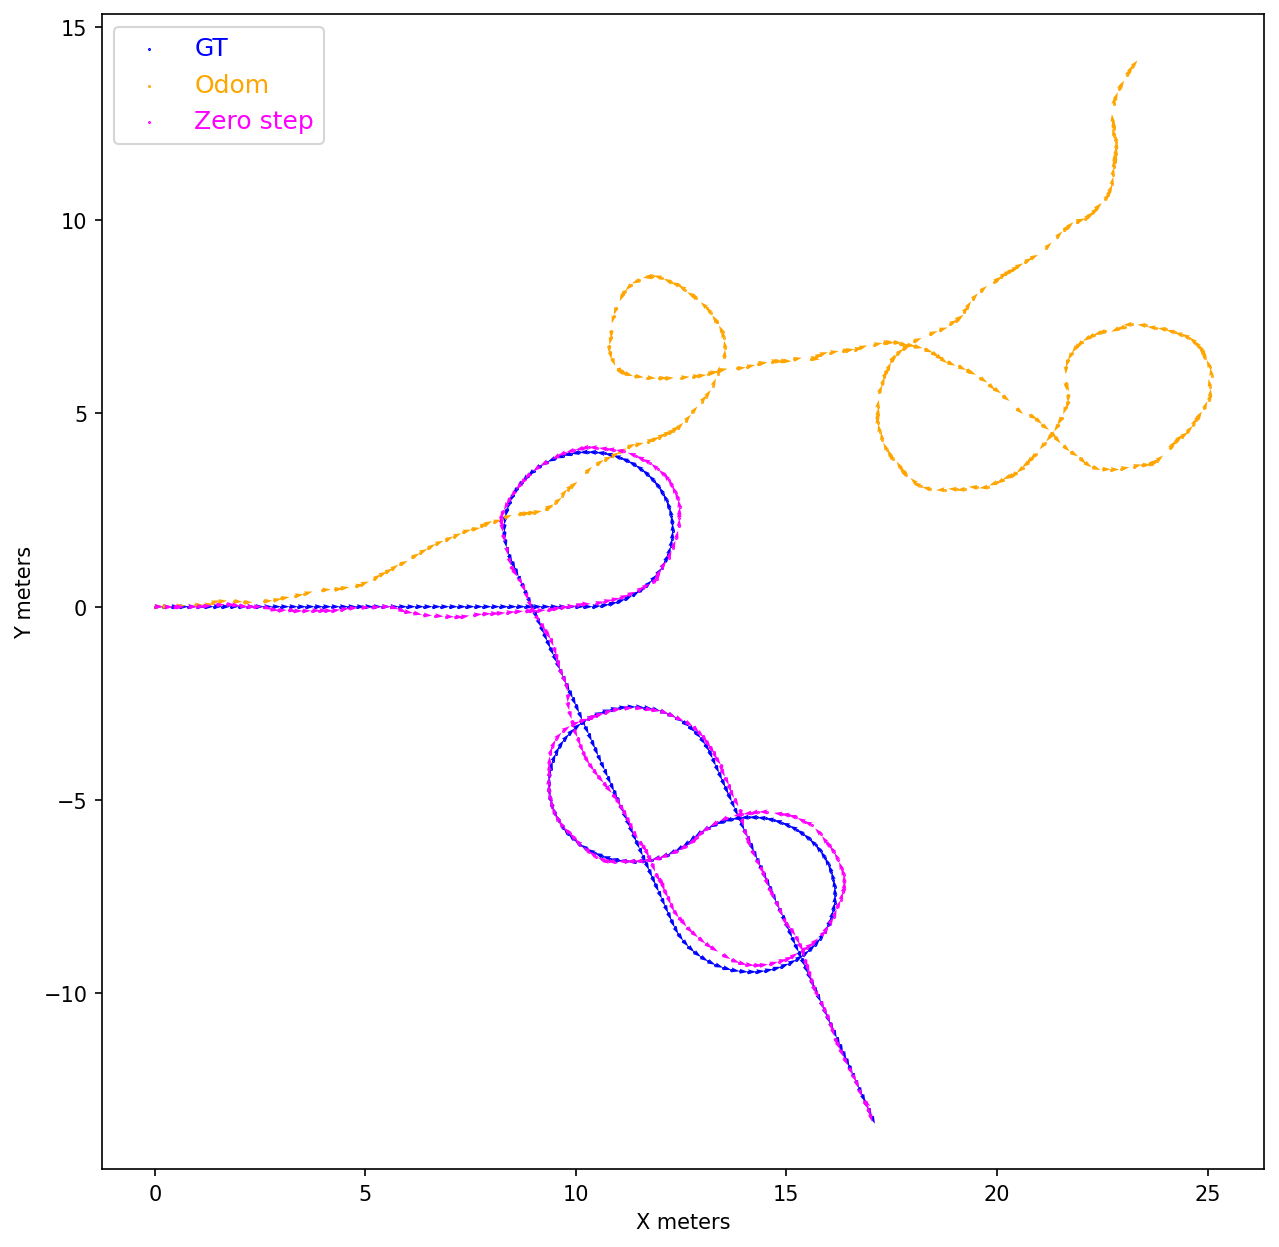

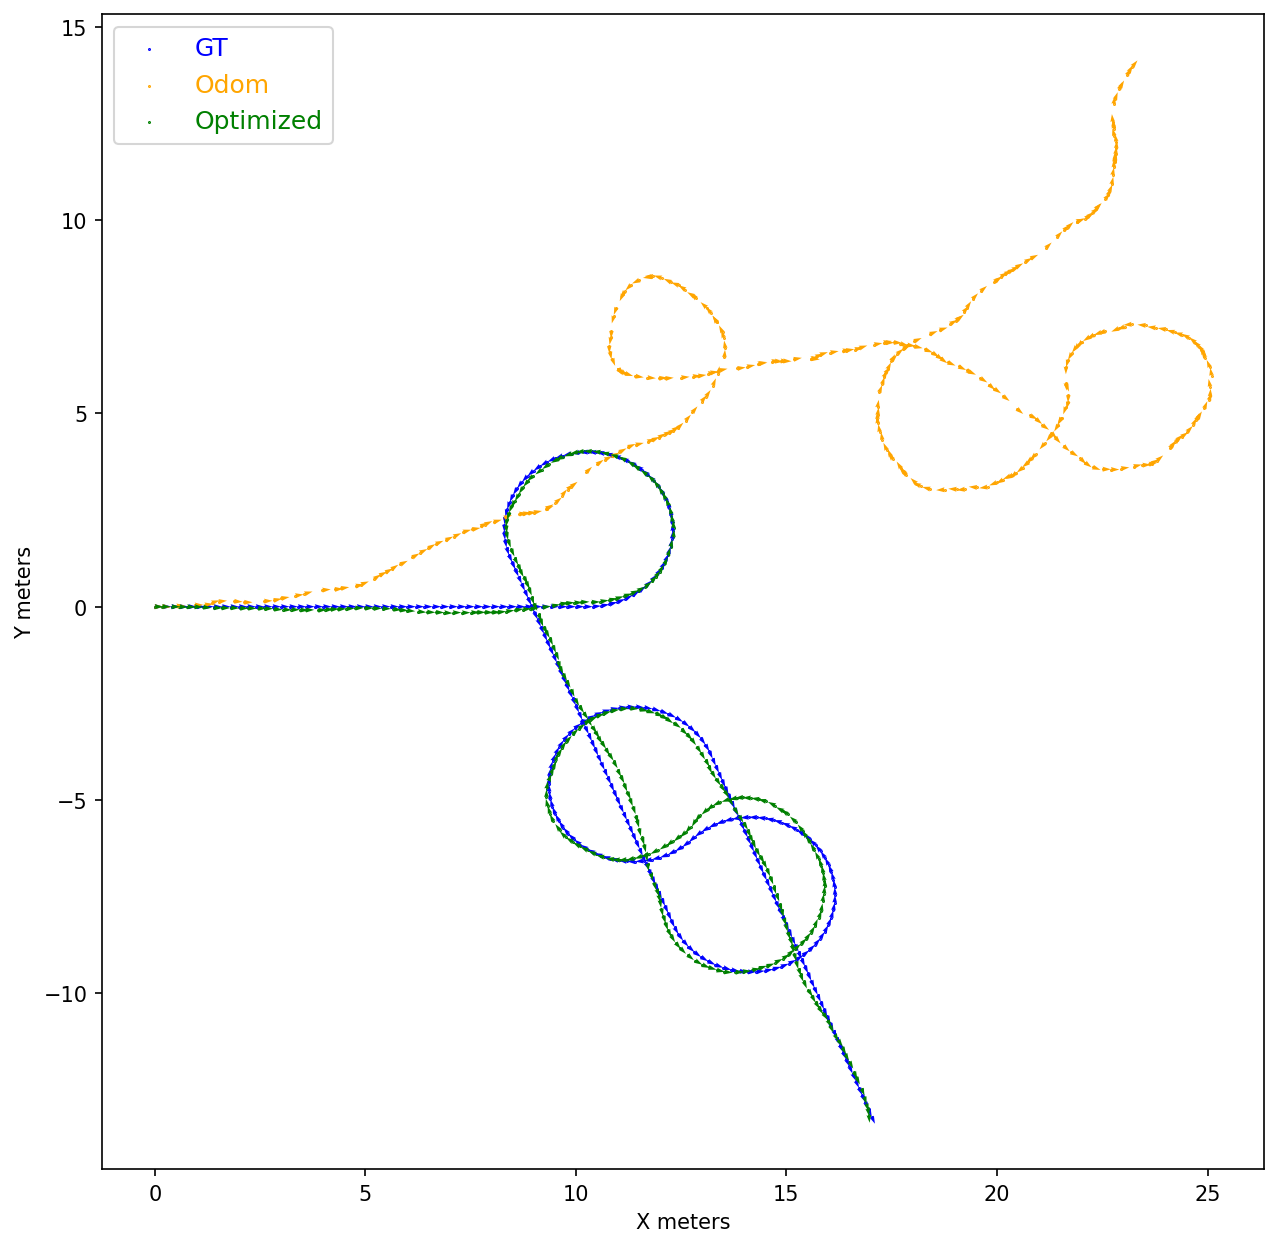


Tree
29.773333635061036
0.011313871601985477 0.009012325128410131
max pos err(m):  0.27
max rot err(deg):  16.72


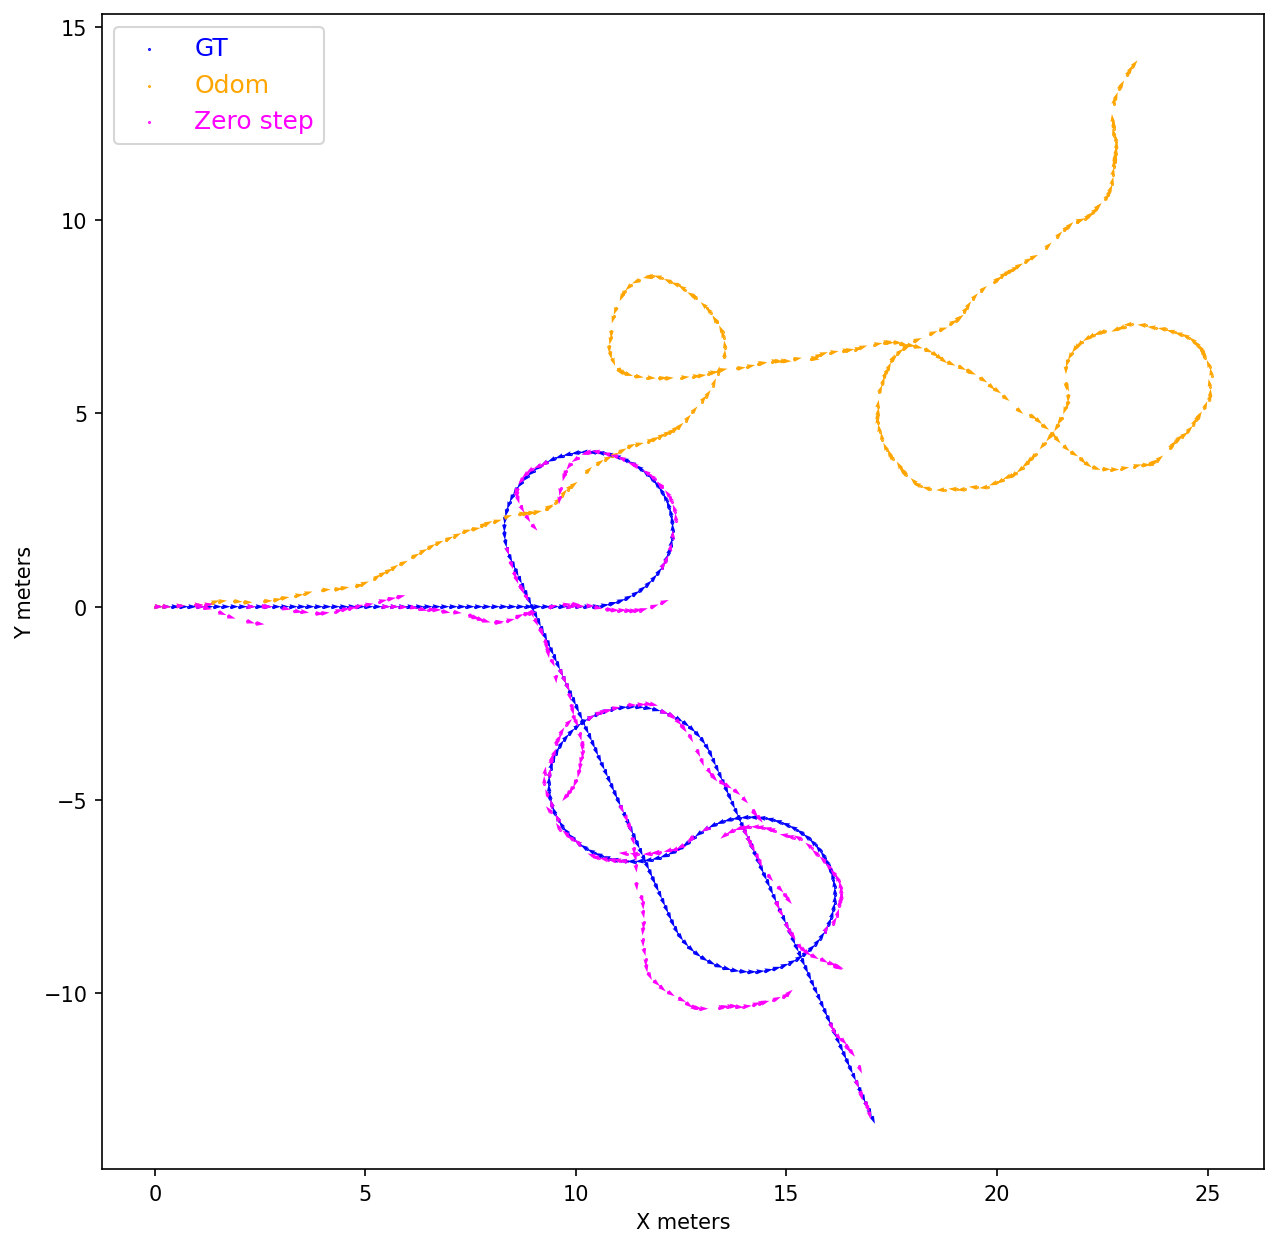

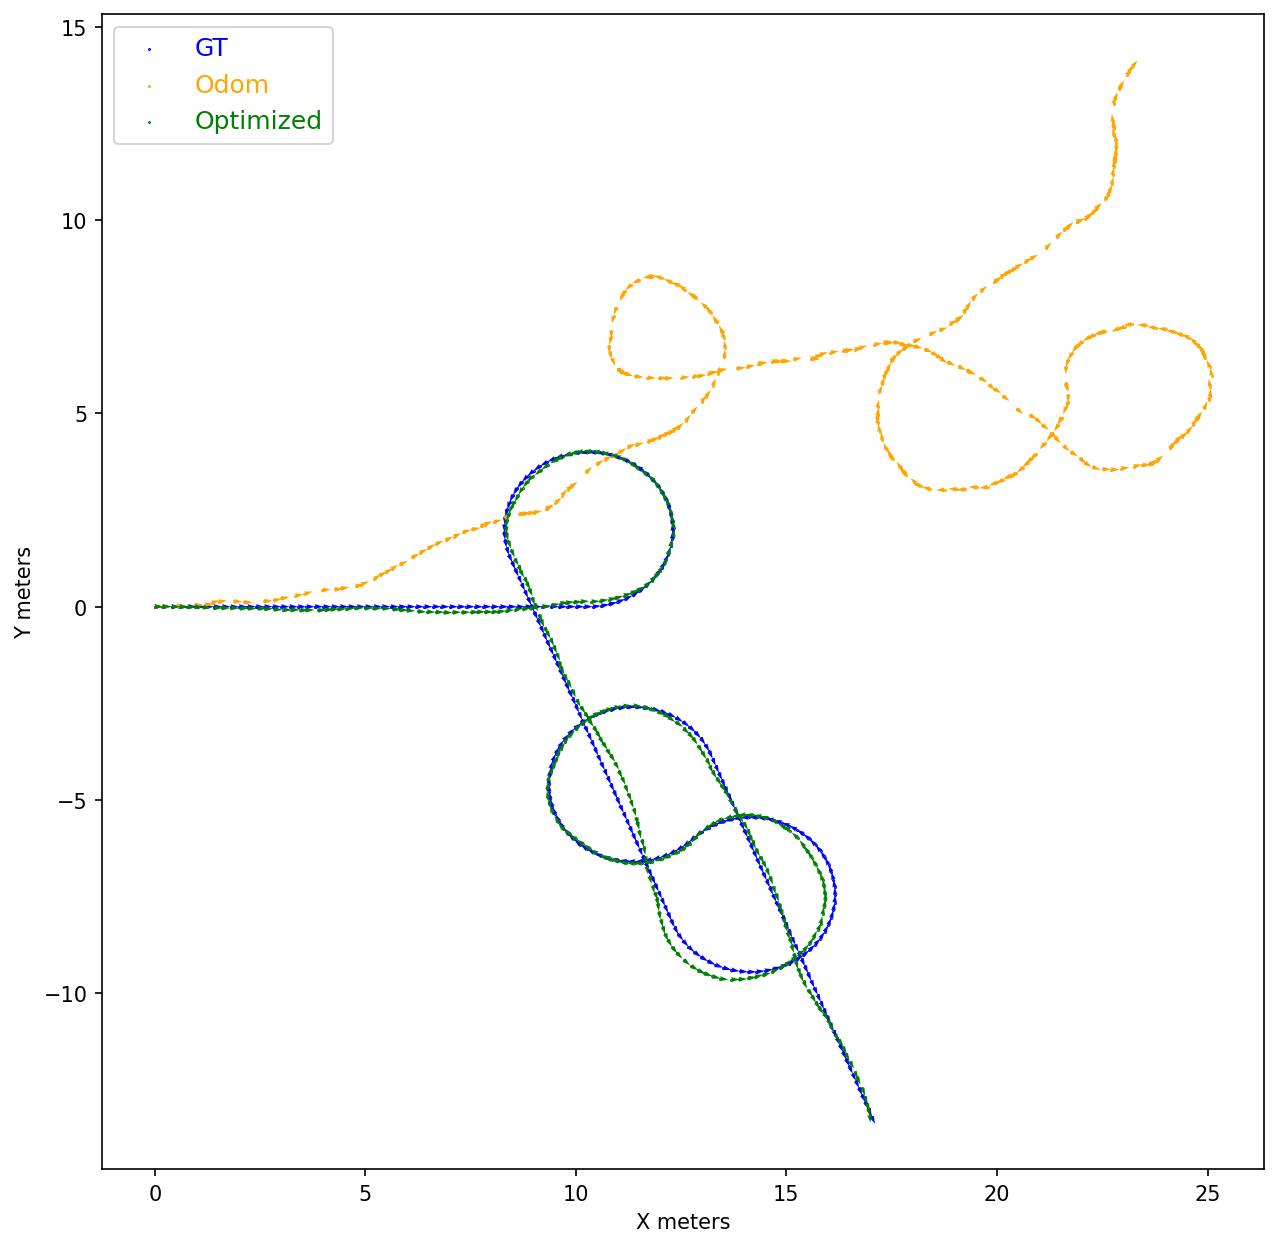

In [18]:
loop_measurements, loop_covariance, odom_measurements, odom_covariance, odom_measurements_1, odom_measurements_2, odom_measurements_3, odom_measurements_4,odom_covariance_1, odom_covariance_2, odom_covariance_3, odom_covariance_4, trajectory_GT,noised_trajectory = gen_data(LoopCount=30)
m = 1
print("\nZeros")
traj = np.zeros_like(trajectory_GT)
optimized_poses,residuals, deltas_norms, trans_mse, rot_mse, chi2 = RUN_EXP(traj, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters = m, noised_trajectory=noised_trajectory)
print("\nRandom")
traj = np.random.normal(loc=0.0, scale=3, size=trajectory_GT.shape)
optimized_poses,residuals, deltas_norms, trans_mse, rot_mse, chi2 = RUN_EXP(traj, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters = m, noised_trajectory=noised_trajectory)
print("\nOdom 1")
traj = integrate_measurements(np.array([0, 0, 0]), odom_measurements_1)
optimized_poses,residuals, deltas_norms, trans_mse, rot_mse, chi2 = RUN_EXP(traj, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters = m, noised_trajectory=noised_trajectory)
print("\nOdom 4")
traj = integrate_measurements(np.array([0, 0, 0]), odom_measurements_4)
optimized_poses,residuals, deltas_norms, trans_mse, rot_mse, chi2 = RUN_EXP(traj, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters = m, noised_trajectory=noised_trajectory)
print("\nCool 1")
traj = cool_preSol(loop_measurements, odom_measurements_1)
optimized_poses,residuals, deltas_norms, trans_mse, rot_mse, chi2 = RUN_EXP(traj, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters = m, noised_trajectory=noised_trajectory)
print("\nCool 4")
traj = cool_preSol(loop_measurements, odom_measurements_4)
optimized_poses,residuals, deltas_norms, trans_mse, rot_mse, chi2 = RUN_EXP(traj, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters = m, noised_trajectory=noised_trajectory)
print("\nTree")
traj = Tree(odom_measurements_1, odom_measurements_2, odom_measurements_3, odom_measurements_4, odom_covariance_1, odom_covariance_2, odom_covariance_3, odom_covariance_4, loop_covariance, loop_measurements).reshape((-1, 3))
optimized_poses,residuals, deltas_norms, trans_mse, rot_mse, chi2 = RUN_EXP(traj, trajectory_GT, odom_measurements, loop_measurements, odom_covariance, loop_covariance, iters = m, noised_trajectory=noised_trajectory)

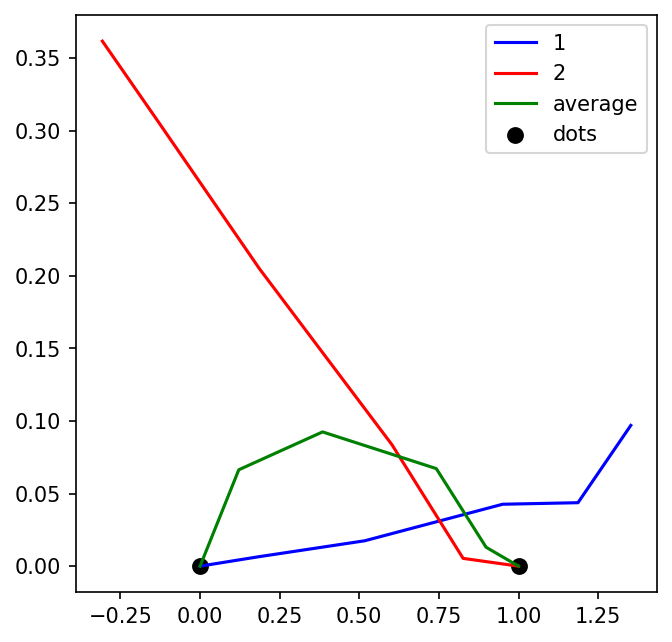

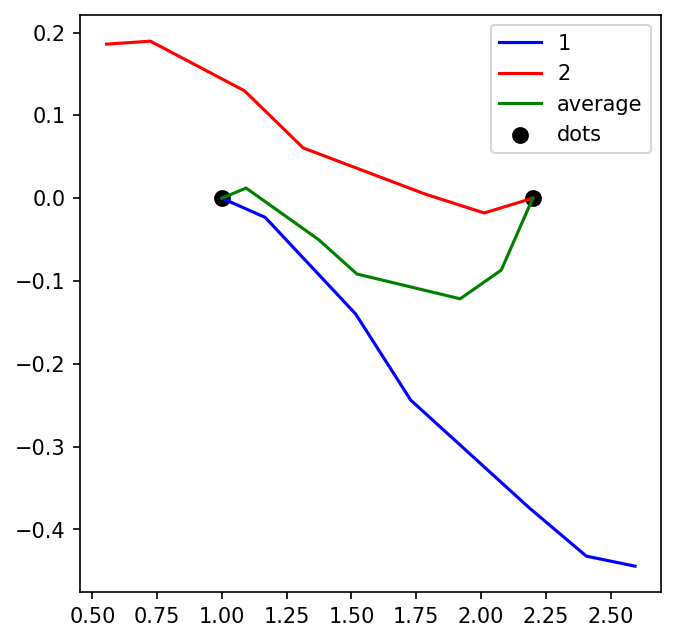

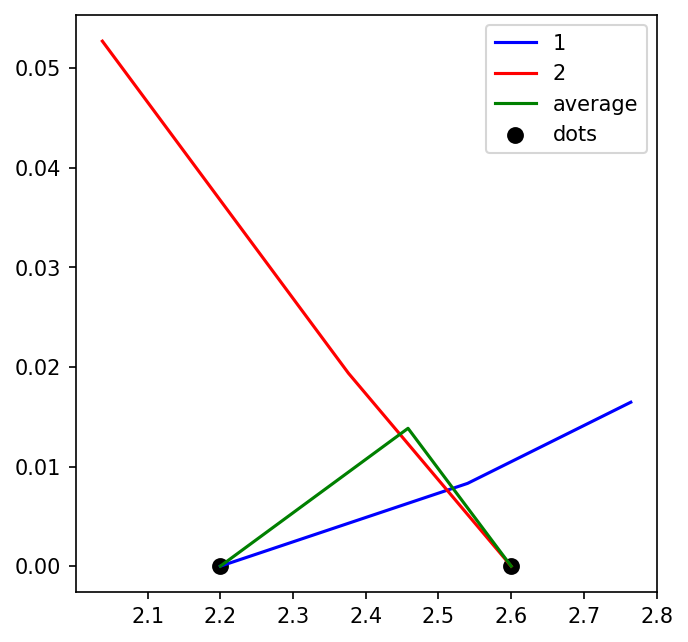

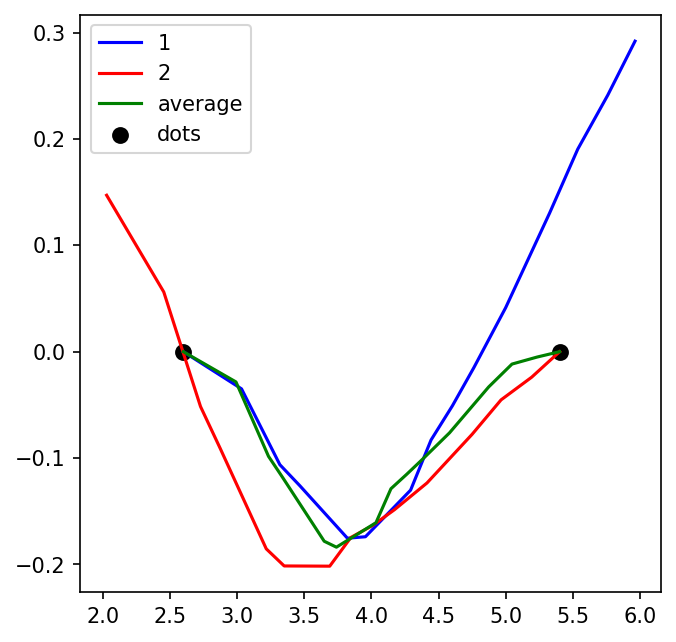

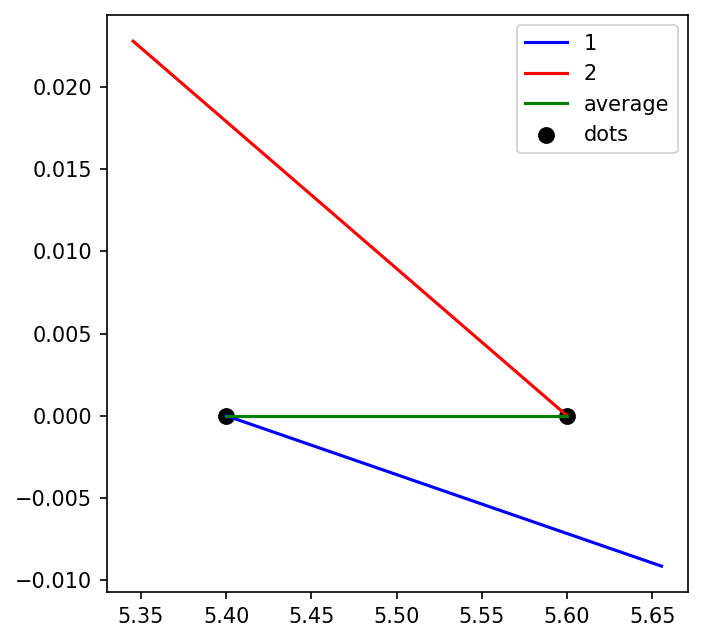

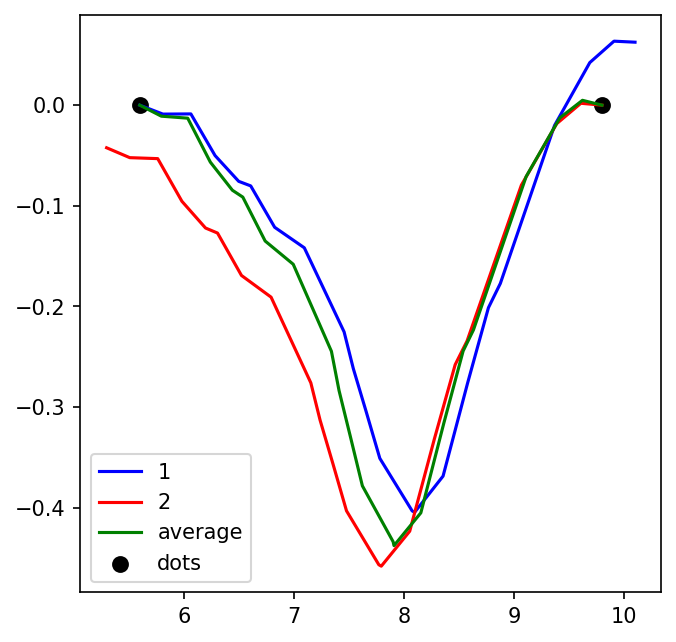

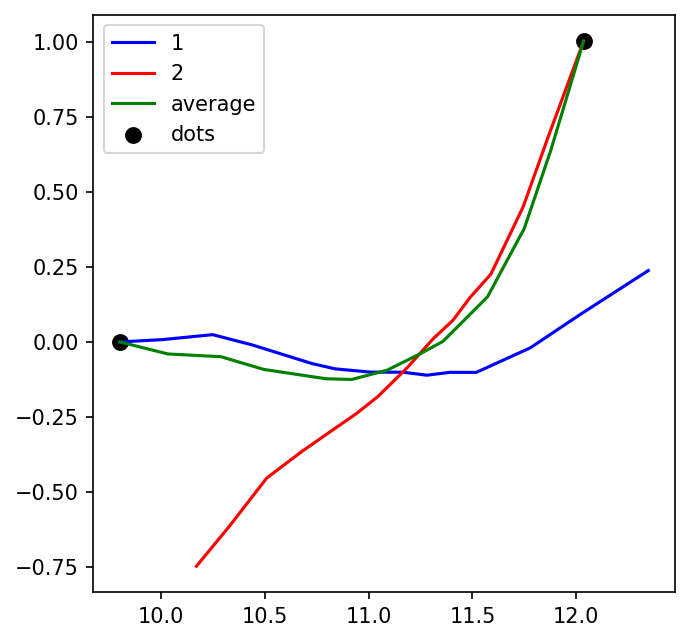

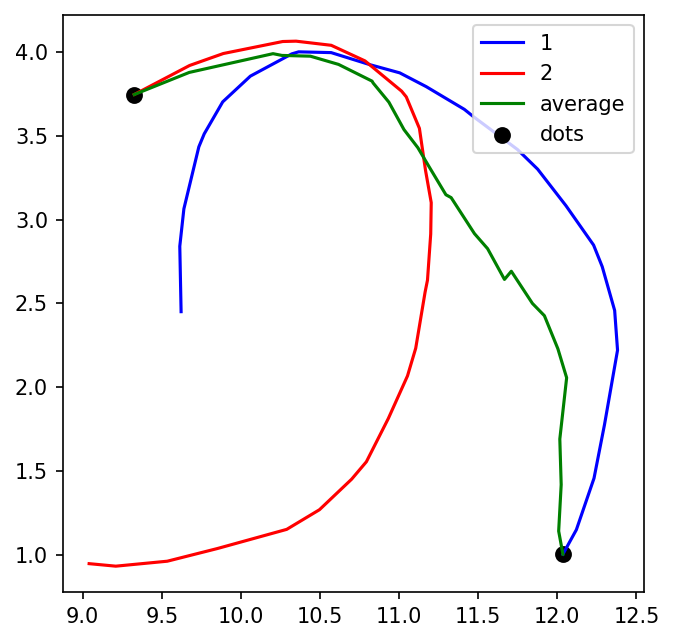

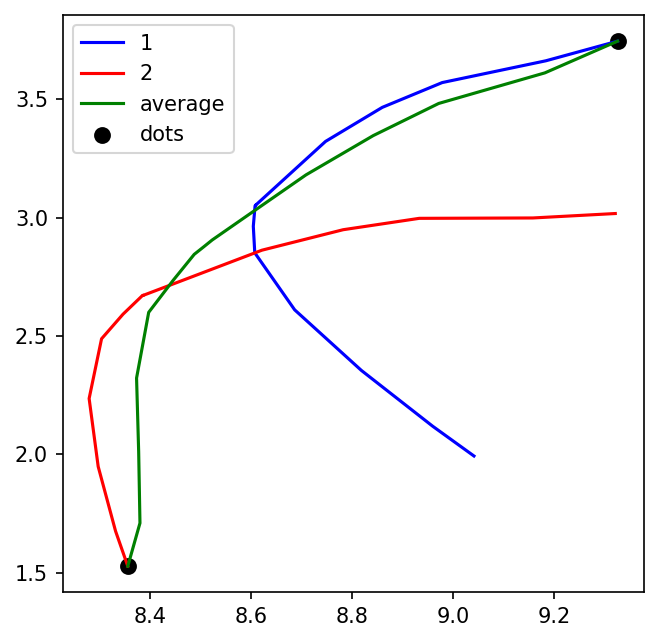

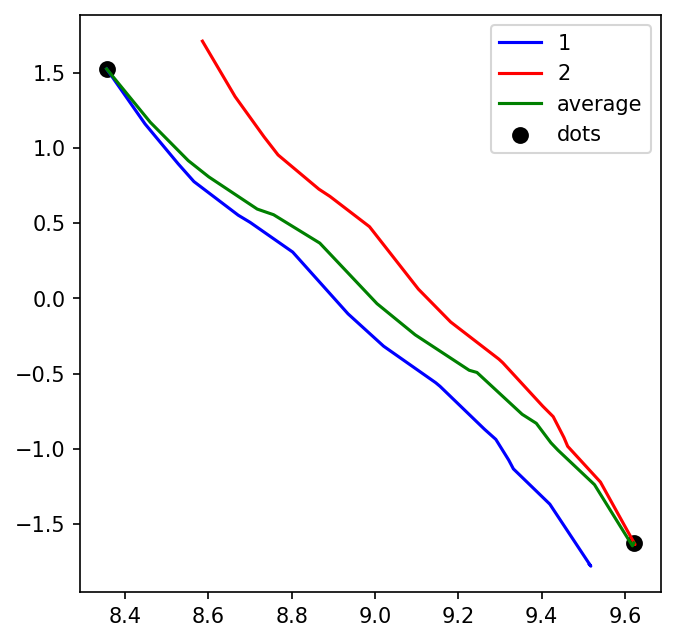

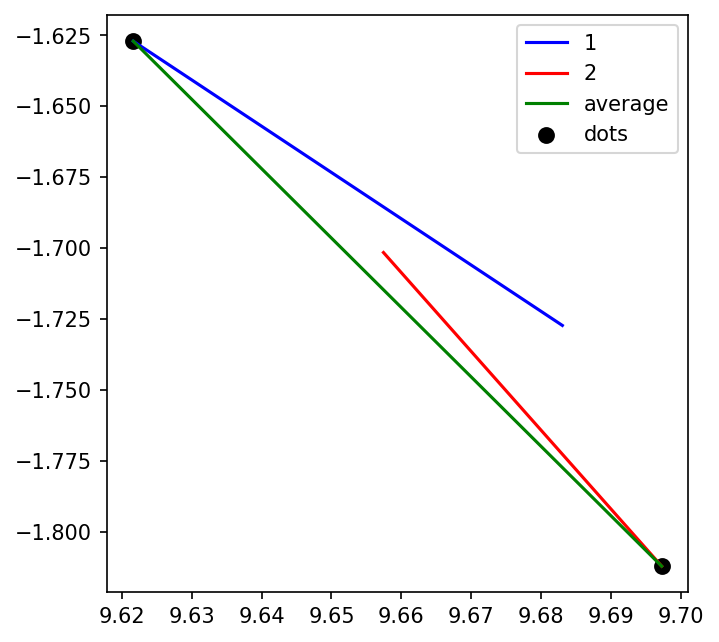

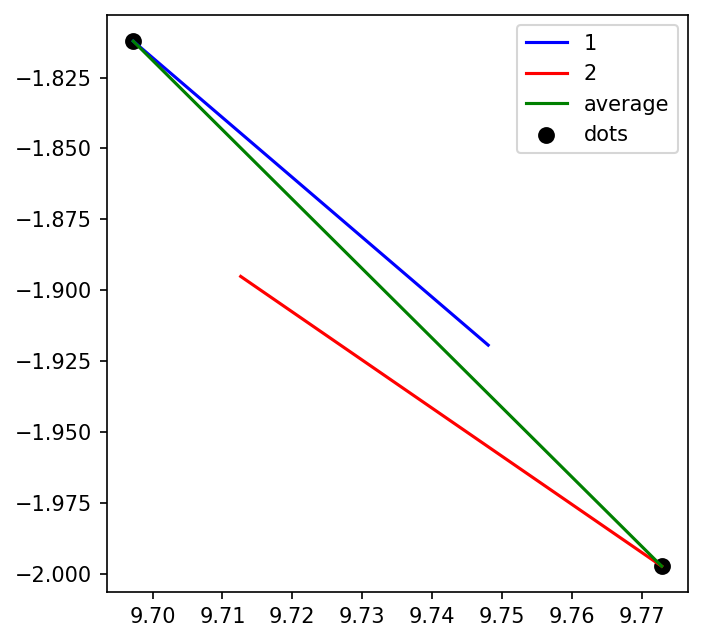

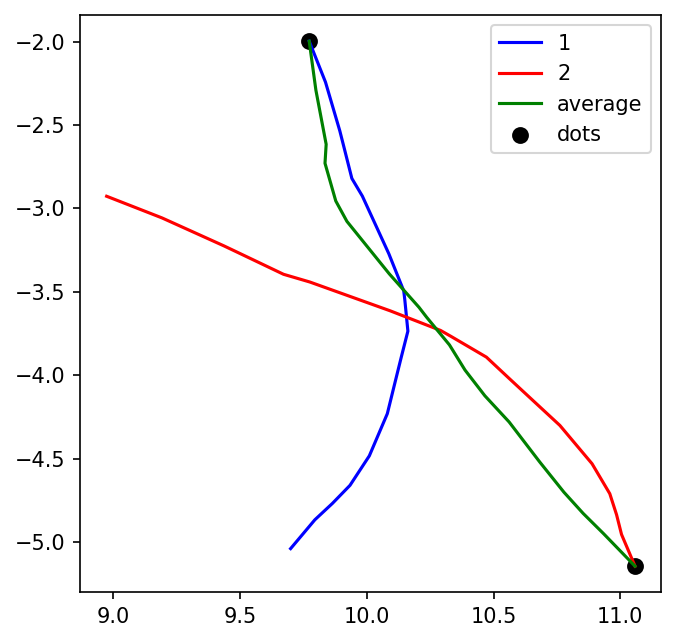

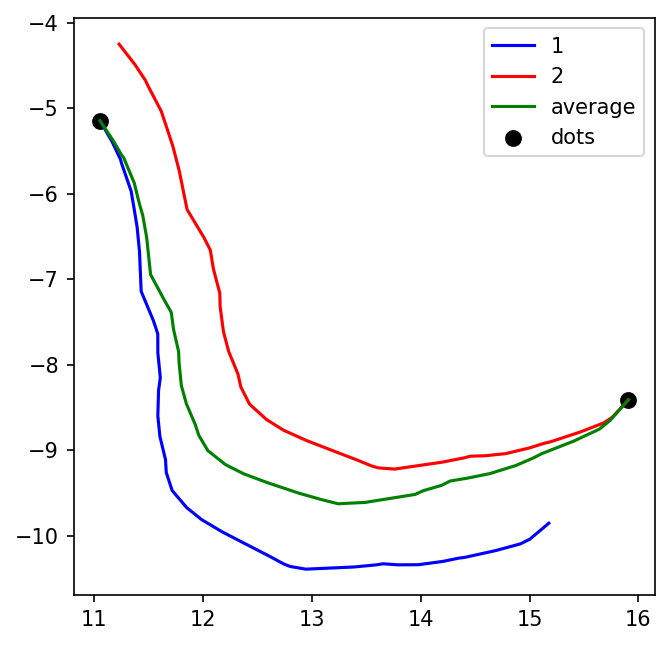

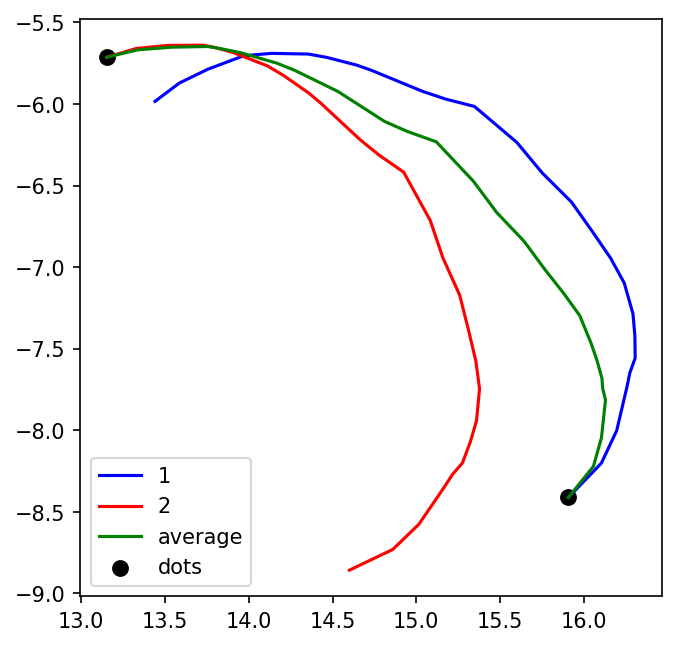

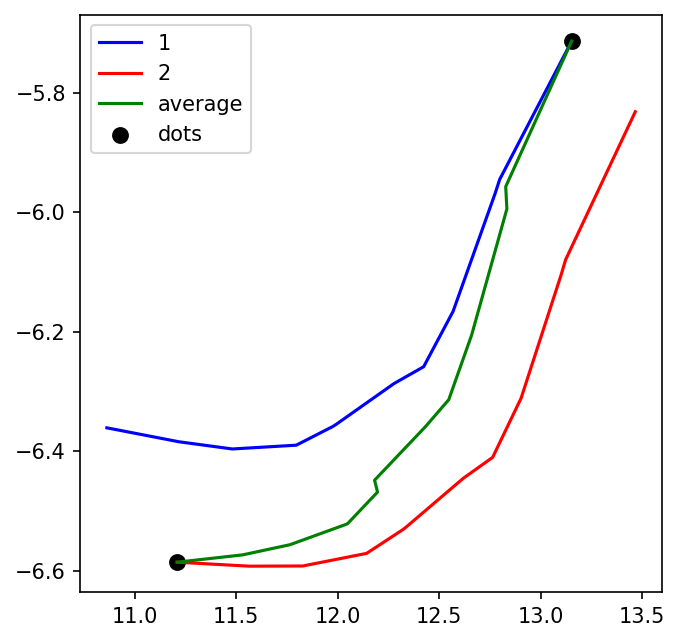

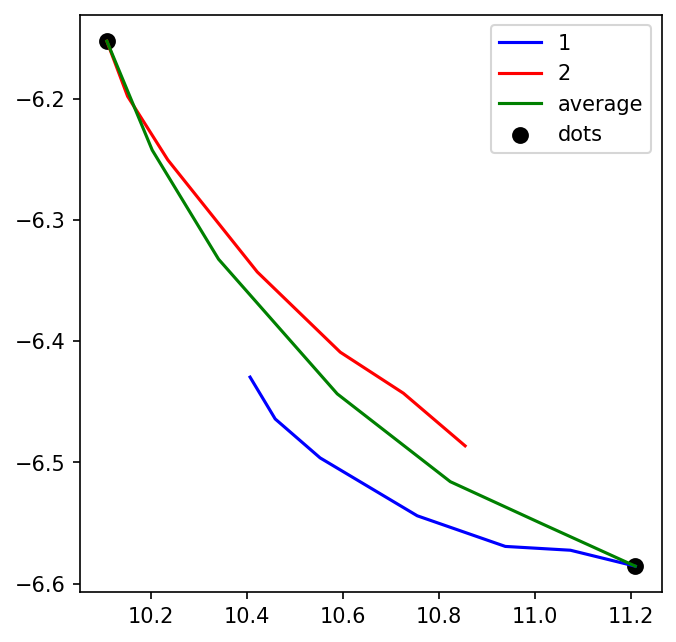

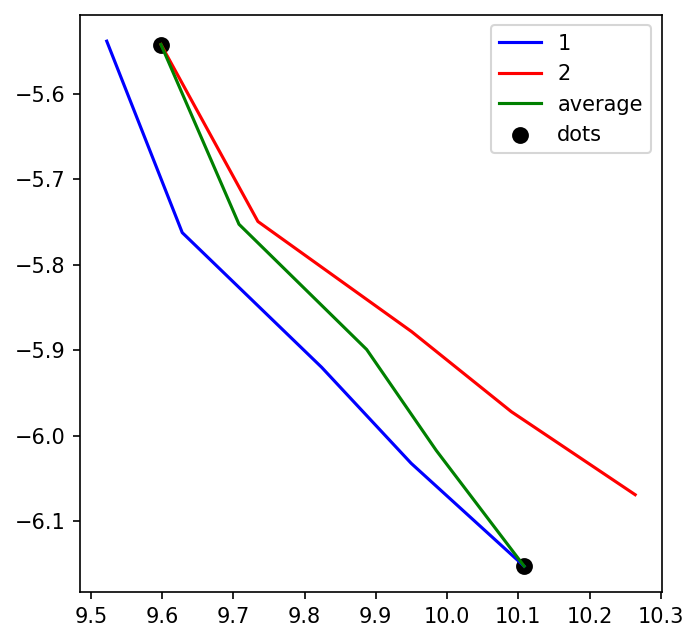

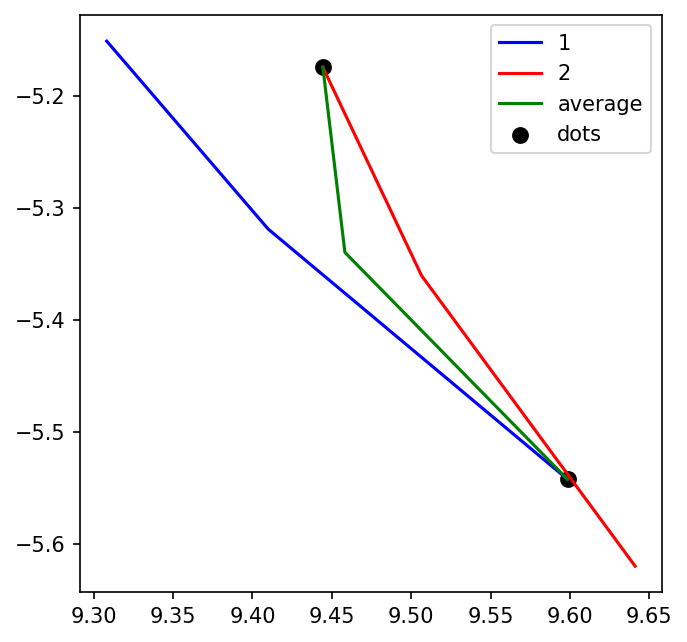

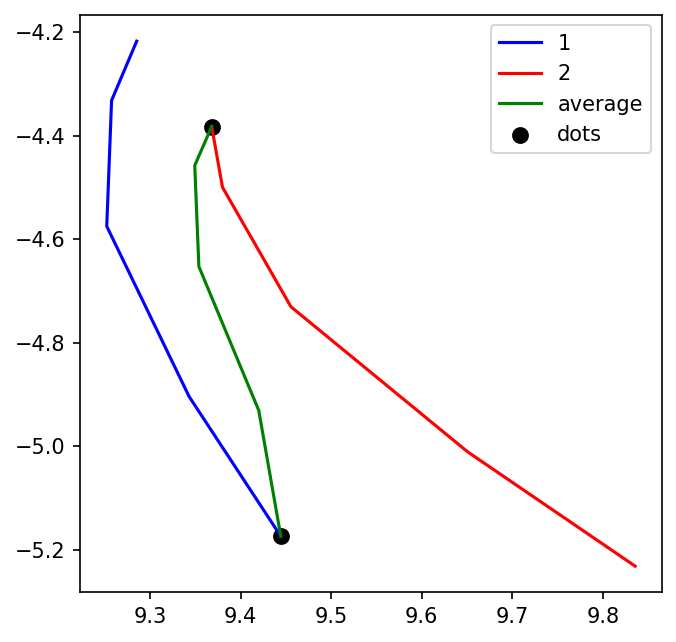

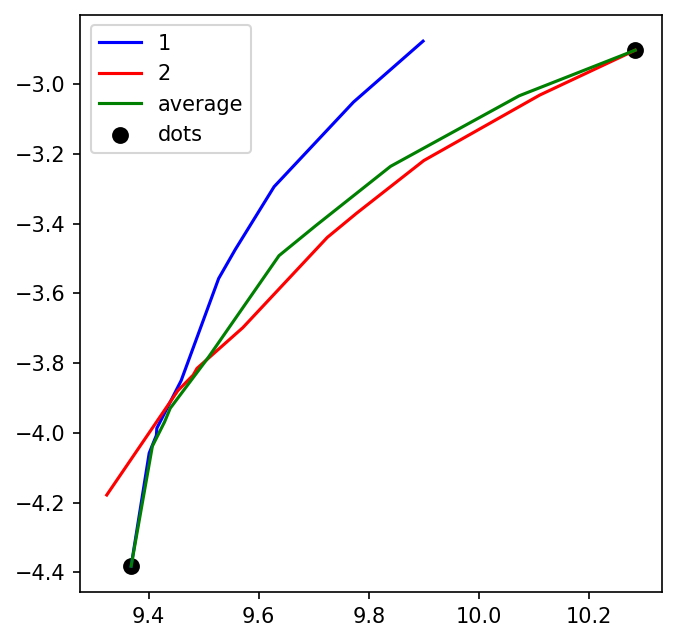

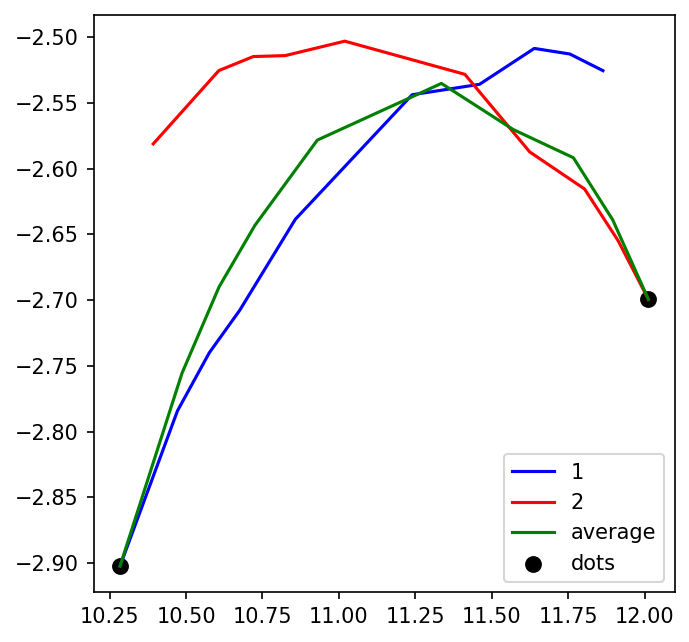

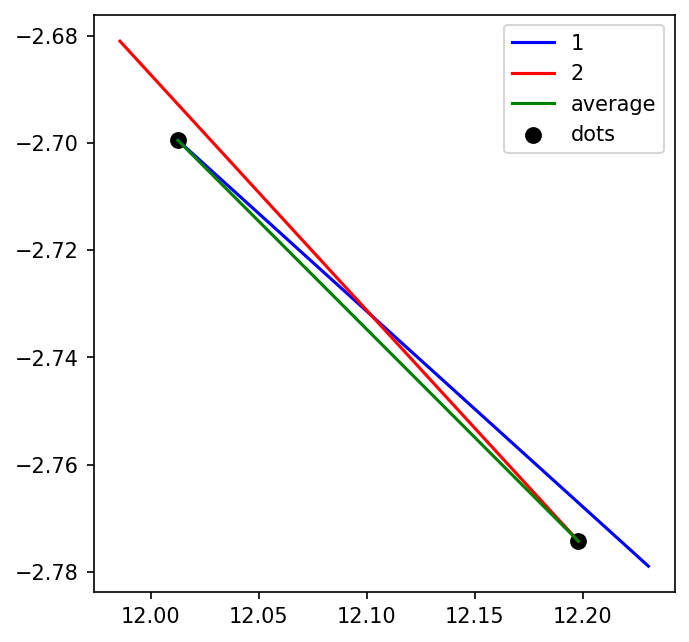

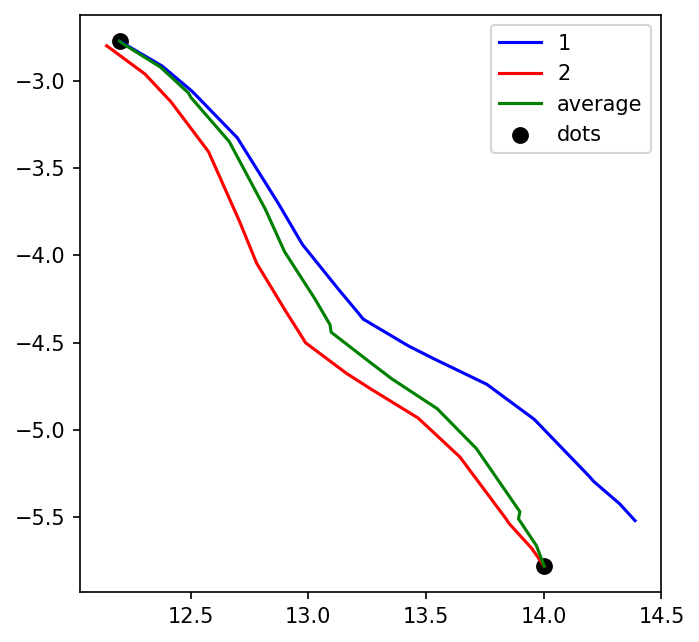

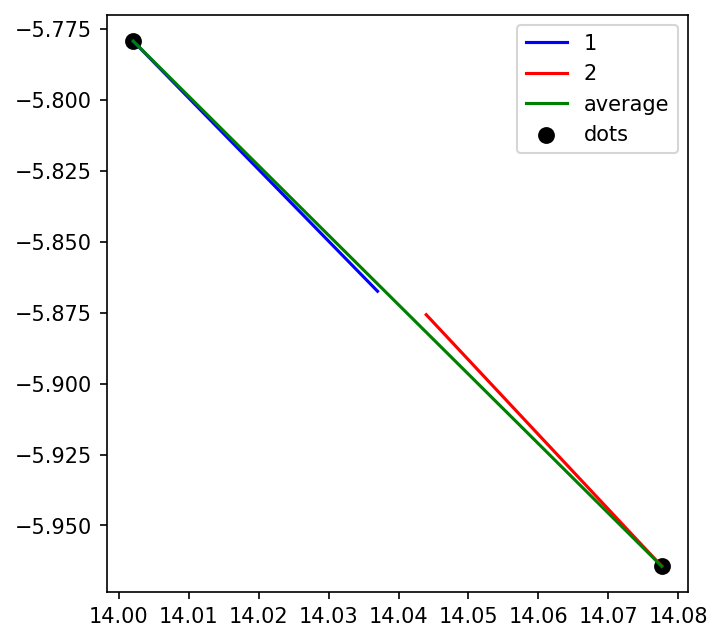

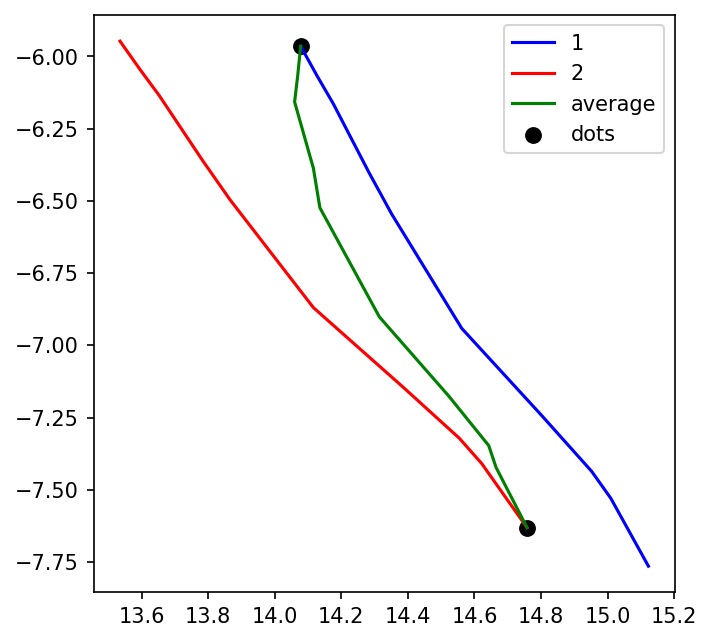

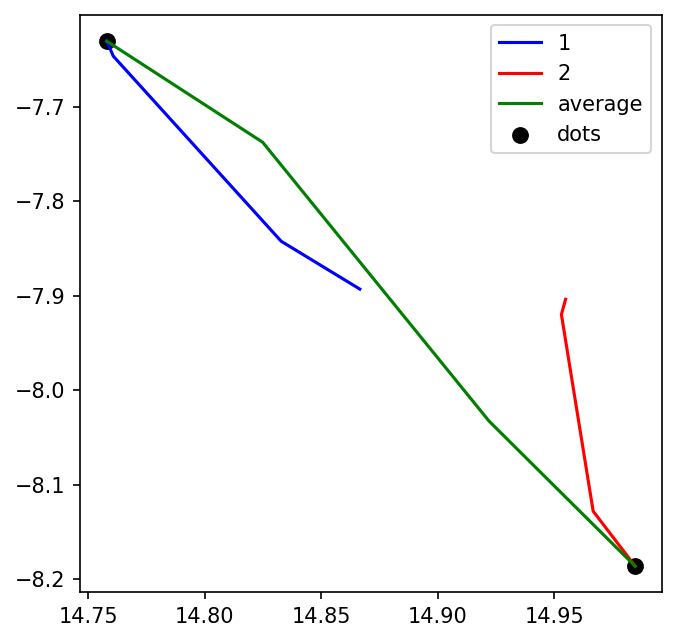

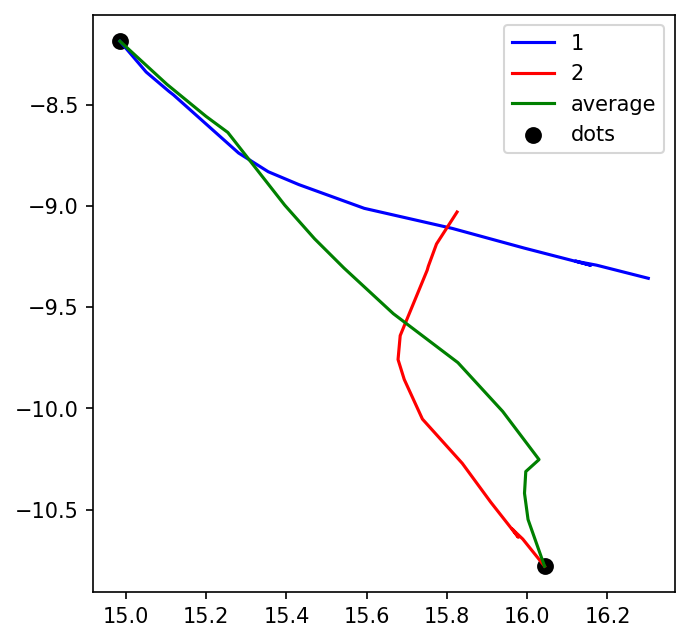

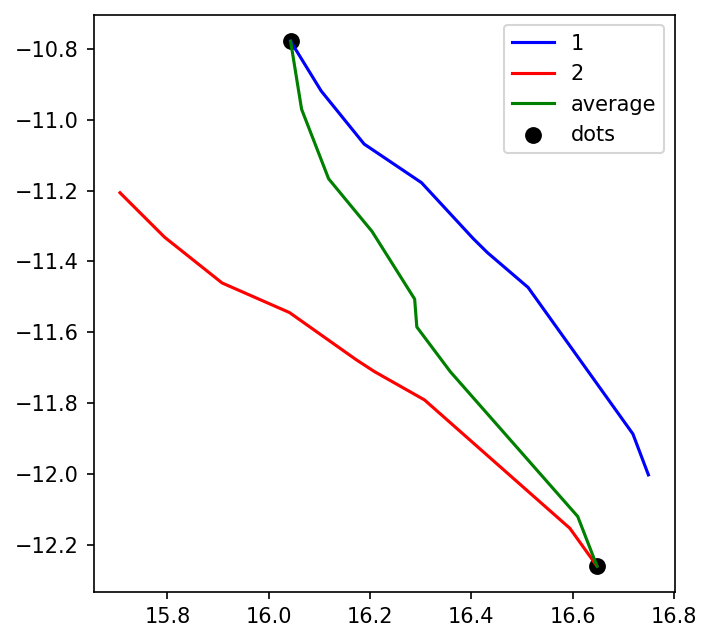

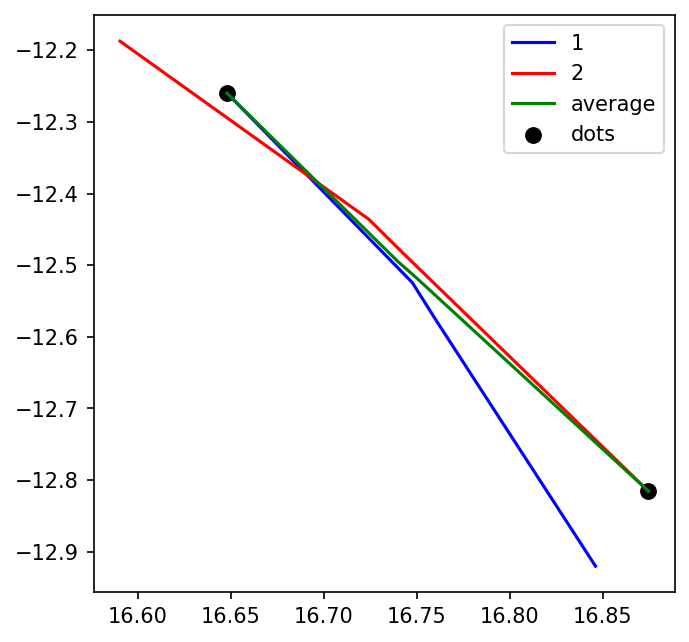

In [20]:
noised_trajectory = integrate_measurements(np.array([0, 0, 0]), odom_measurements_1)
    
loop_mes = np.concatenate((np.array([[0, 0, 0, 0, 0]]),  loop_measurements.copy()))
loop_mes=loop_mes[np.argsort(loop_mes[:,1])]
cooler_traj = np.ndarray((0, 3))
for i in range(1, len(loop_mes)):
    loc_traj = noised_trajectory[int(loop_mes[i-1, 1]):int(loop_mes[i, 1])+1]
    R1 = get_R(-loc_traj[0, 2]+loop_mes[i-1, 4])
    loc_traj1 = (R1@(loc_traj - loc_traj[0]).T).T + np.concatenate((loop_mes[i-1, [2, 3]], [0]))
    R2 = get_R(-loc_traj[-1, 2]+loop_mes[i, 4])
    loc_traj2 = (R2@(loc_traj - loc_traj[-1]).T).T+np.concatenate((loop_mes[i, [2, 3]], [0]))
    loc_traj3 = loc_traj.copy()
    N = len(loc_traj)-1
    loc_traj3 = (loc_traj2.T*np.linspace(0, 1, loc_traj2.shape[0])).T + (loc_traj1.T*np.linspace(1, 0, loc_traj2.shape[0])).T
    fig, ax = plt.subplots(figsize=(5,5),dpi=150)
    ax.plot(loc_traj1[:,0],loc_traj1[:,1], label='1',c='blue')
    ax.plot(loc_traj2[:,0],loc_traj2[:,1], label='2',c='red')
    ax.plot(loc_traj3[:,0],loc_traj3[:,1], label='average',c='green')
    ax.scatter(loc_traj3[[0, -1],0],loc_traj3[[0, -1],1], s=50, label='dots',c='black')
    ax.legend()
    plt.savefig('comment.png')
    plt.show()
    